<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/Relaxation_PINN_Correct._BGK_06_21ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Characteristic Probability Density (P_c): 0.0030 s/m
Set the default float type to float32
Compiling model...
'compile' took 0.006701 s

شروع آموزش با Adam...
Training model...

Step      Train loss              Test loss               Test metric
0         [4.51e-02, 2.38e-02]    [4.94e-02, 2.38e-02]    []  
2000      [5.37e-06, 8.36e-06]    [4.64e-06, 8.34e-06]    []  
4000      [1.64e-07, 1.92e-08]    [1.58e-07, 1.88e-08]    []  
6000      [1.61e-07, 3.83e-08]    [1.83e-07, 4.66e-08]    []  
8000      [5.16e-06, 9.77e-06]    [3.75e-06, 9.89e-06]    []  
10000     [8.44e-07, 1.62e-07]    [9.78e-07, 1.66e-07]    []  
12000     [5.08e-08, 1.13e-09]    [5.38e-08, 1.27e-09]    []  
14000     [4.40e-07, 9.99e-08]    [4.93e-07, 1.02e-07]    []  
16000     [1.42e-06, 6.84e-07]    [1.56e-06, 6.88e-07]    []  
18000     [3.09e-07, 2.79e-07]    [3.05e-07, 2.83e-07]    []  
20000     [1.13e-08, 2.02e-09]    [1.04e-08, 1.8

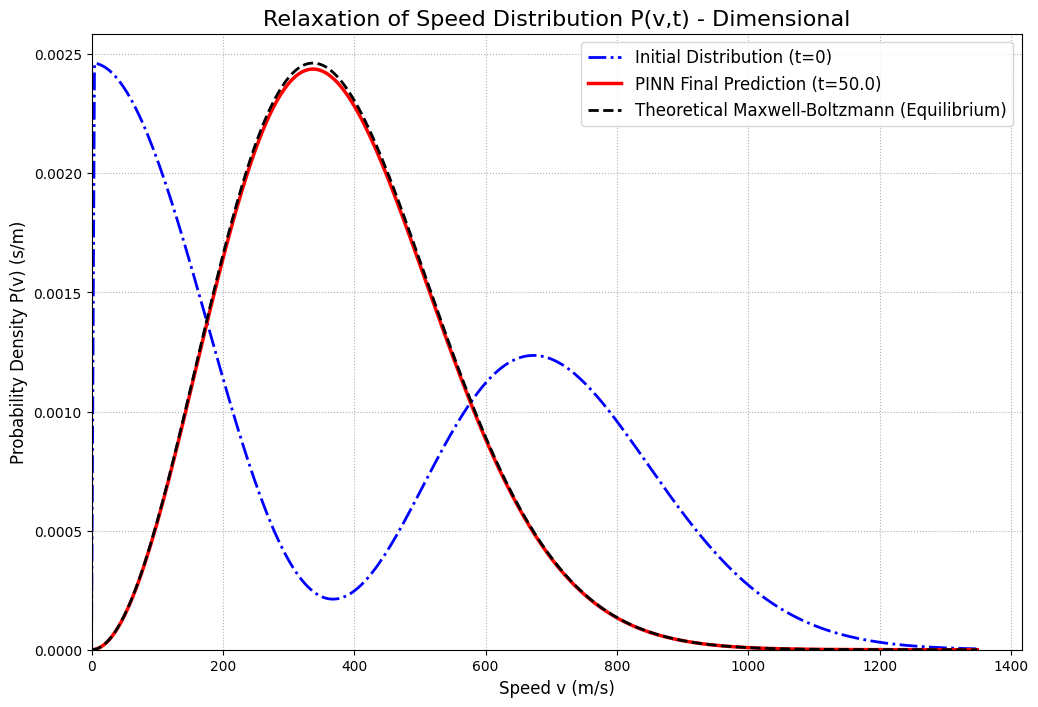

In [4]:
# -*- coding: utf-8 -*-
"""
کد نهایی برای حل مسئله رهایش با PINN

--- نسخه نهایی با رویکرد یادگیری انحراف از تعادل (Φ) برای حداکثر پایداری ---
--- اصلاح شده برای مقیاس‌بندی صحیح، رفع خطا و ذخیره نمودار در فایل ---
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
  except RuntimeError as e:
    print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترها ---
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

# سرعت مشخصه (محتمل‌ترین سرعت در توزیع ماکسول-بولتزمن)
V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS

print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 4.0
ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 50.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """
    تابع توزیع سرعت ماکسول-بولتزمن بی‌بعد شده.
    این تابع به گونه‌ای نرمال شده که انتگرال آن روی v_hat از ۰ تا بی‌نهایت برابر با ۱ شود.
    P_M_hat = (4/sqrt(pi)) * v_hat^2 * exp(-v_hat^2)
    """
    return (4 / np.sqrt(np.pi)) * v_hat**2 * tf.exp(-v_hat**2)

# --- تعریف PDE و IC بر حسب Φ ---
def pde_phi(x, Phi):
    # x = [t_hat, v_hat]
    # Phi = خروجی شبکه عصبی

    # معادله ساده شده برای انحراف از تعادل: d(Phi)/dt = -w(t) * Phi
    dPhi_dt_hat = dde.grad.jacobian(Phi, x, i=0, j=0)

    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat) # ضریب رهایش که به تدریج فعال می‌شود

    return dPhi_dt_hat + w_that * Phi

@tf.function
def initial_phi(x):
    # Φ(t=0) = P_initial(v) / P_M(v) - 1
    v_hat = x[:, 1:2]

    # یک توزیع اولیه غیرتعادلی (دو قله‌ای) برای تست
    # برای نرمال‌سازی صحیح، از انتگرال‌گیری عددی (جمع ریمان) استفاده می‌کنیم
    v_space = tf.linspace(0., SPEED_MAX_NONDIM, 1000)
    term1_space = 0.5 * maxwell_boltzmann_nondim(v_space - 1.0)
    term2_space = 0.5 * maxwell_boltzmann_nondim(v_space + 1.0)

    # این روش با @tf.function کاملا سازگار است
    integral_val = tf.reduce_sum(term1_space + term2_space) * (v_space[1] - v_space[0])

    term1 = 0.5 * maxwell_boltzmann_nondim(v_hat - 1.0)
    term2 = 0.5 * maxwell_boltzmann_nondim(v_hat + 1.0)
    p_initial_hat = (term1 + term2) / integral_val

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    # برای جلوگیری از تقسیم بر صفر در v=0
    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))


# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    geom = dde.geometry.Interval(0, SPEED_MAX_NONDIM)
    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(
        geomtime,
        pde_phi,
        [ic],
        num_domain=20000,
        num_initial=4000,
        num_test=4000,
    )

    # شبکه عصبی Φ را یاد می‌گیرد
    net = dde.maps.FNN([2] + [60] * 5 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # تعریف تابع سازنده برای تابع زیان سفارشی شامل قید پایستگی
    def create_loss_factory(model_instance, num_integral_pts=4096):
        # نقاط ثابت برای انتگرال‌گیری مونت کارلو جهت پایداری
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))

        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            # قید پایستگی: ∫ P_M * Φ dv_hat = 0
            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)
            phi_hat_at_integral_points = model_instance.net(integral_anchors)

            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points

            # انتگرال‌گیری مونت کارلو
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume
            conservation_loss = tf.square(integral_value)

            return original_loss + conservation_loss * CONSERVATION_LOSS_WEIGHT

        return loss_func

    final_loss_fn = create_loss_factory(model)
    model.compile("adam", lr=1e-3, loss=final_loss_fn)

    print("شروع آموزش با Adam...")
    losshistory, train_state = model.train(epochs=40000, display_every=2000)

    print("\nشروع آموزش با L-BFGS...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory, train_state = model.train()

    # --- افزایش اندازه فونت برای رسم نمودار ---
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'axes.titlesize': 18
    })

    print("\nرسم و ذخیره‌سازی نتایج...")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 300).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    x_final_hat = np.hstack((t_hat_final, v_hat_plot))

    # پیش‌بینی Φ و ساخت P_hat
    phi_final_hat_pred = model.predict(x_final_hat)
    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    # بازگرداندن ابعاد برای رسم نمودار
    # v = v_hat * V_CHAR
    # P(v) = P_hat(v_hat) / V_CHAR

    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label='PINN Final Distribution (t -> inf)')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t) - Dimensional')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))

    # --- خط جدید برای ذخیره نمودار ---
    # این دستور نمودار را با نام 'relaxation_pinn_result.jpg' ذخیره می‌کند.
    # dpi=300 کیفیت تصویر را بالا می‌برد.
    # bbox_inches='tight' حاشیه‌های سفید اضافی را حذف می‌کند.
    plt.savefig('relaxation_pinn_result.jpg', dpi=300, bbox_inches='tight')

    # نمایش نمودار در خروجی
    plt.show()

    print("\nنمودار با موفقیت در فایل 'relaxation_pinn_result.jpg' ذخیره شد.")

In [2]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.3 MB/s eta 0:00:00


1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Set the default float type to float32
Compiling model...
'compile' took 0.007071 s

شروع آموزش با Adam...
Training model...

Step      Train loss              Test loss               Test metric
0         [3.92e-02, 1.80e-02]    [4.35e-02, 1.80e-02]    []  
2000      [2.18e-06, 3.24e-07]    [2.31e-06, 3.08e-07]    []  
4000      [8.63e-06, 9.96e-07]    [1.02e-05, 9.95e-07]    []  
6000      [1.13e-07, 7.67e-09]    [1.24e-07, 1.00e-08]    []  
8000      [1.79e-07, 3.17e-08]    [1.89e-07, 3.15e-08]    []  
10000     [3.99e-08, 4.03e-09]    [4.27e-08, 4.59e-09]    []  
12000     [1.18e-07, 8.18e-09]    [1.18e-07, 8.18e-09]    []  
14000     [2.50e-08, 4.64e-09]    [2.18e-08, 4.67e-09]    []  
16000     [1.02e-08, 1.58e-09]    [1.15e-08, 1.53e-09]    []  
18000     [2.91e-08, 1.19e-09]    [3.39e-08, 1.23e-09]    []  
20000     [8.75e-08, 6.42e-09]    [7.64e-08, 6.69e-09]    []  
22000     [1.46e-08, 2.63e-09]    [1.0

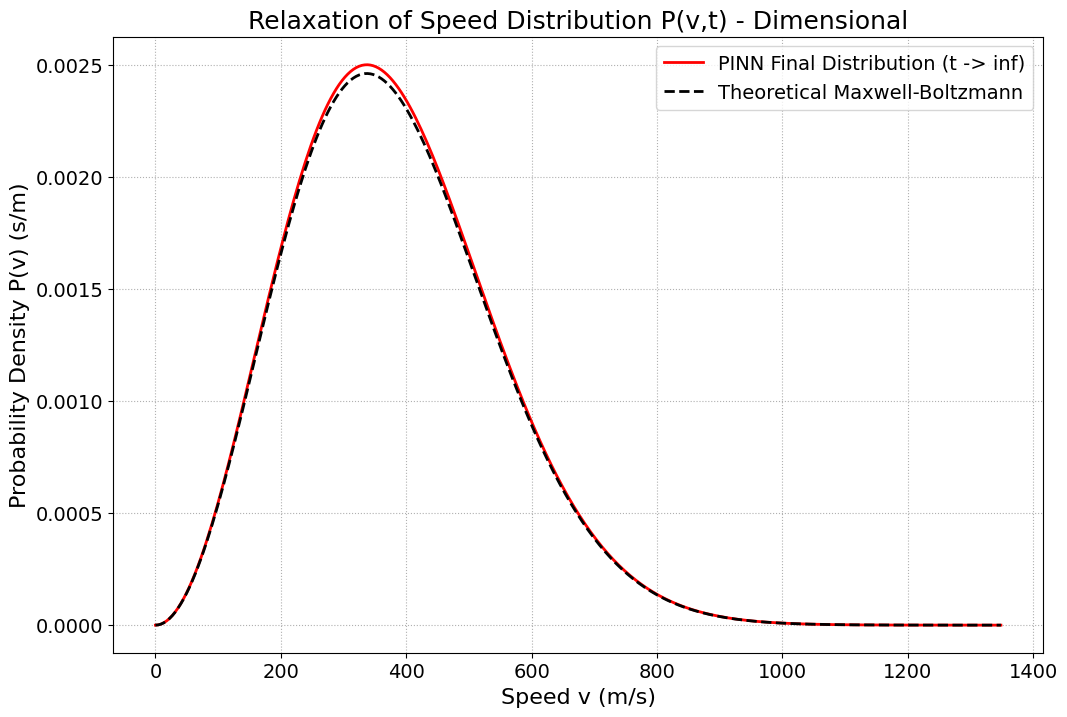


نمودار تابع توزیع با موفقیت در فایل 'relaxation_pinn_result.jpg' ذخیره شد.

رسم و ذخیره‌سازی نمودار همگرایی...


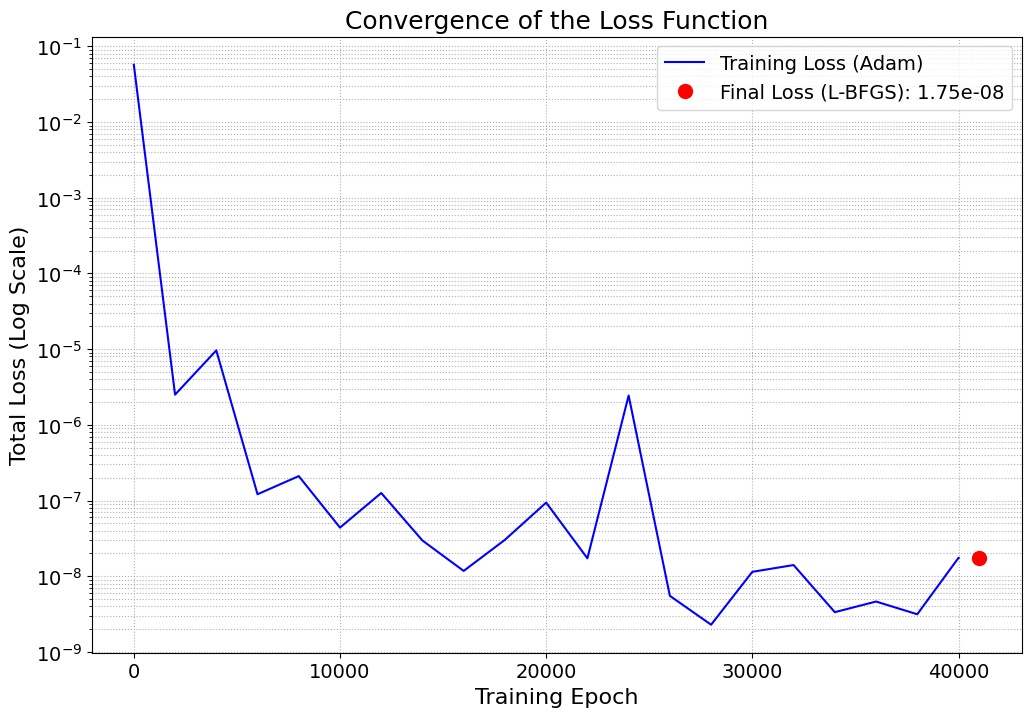


نمودار همگرایی با موفقیت در فایل 'loss_convergence.jpg' ذخیره شد.


In [18]:
# -*- coding: utf-8 -*-
"""
کد نهایی برای حل مسئله رهایش با PINN

--- نسخه نهایی با رویکرد یادگیری انحراف از تعادل (Φ) برای حداکثر پایداری ---
--- اصلاح شده برای مقیاس‌بندی صحیح، رفع خطا و ذخیره نمودار در فایل ---
--- افزوده شدن نمودار همگرایی شبکه ---
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترها ---
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

# سرعت مشخصه (محتمل‌ترین سرعت در توزیع ماکسول-بولتزمن)
V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS

print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 4.0
ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 50.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """
    تابع توزیع سرعت ماکسول-بولتزمن بی‌بعد شده.
    این تابع به گونه‌ای نرمال شده که انتگرال آن روی v_hat از ۰ تا بی‌نهایت برابر با ۱ شود.
    P_M_hat = (4/sqrt(pi)) * v_hat^2 * exp(-v_hat^2)
    """
    return (4 / np.sqrt(np.pi)) * v_hat**2 * tf.exp(-v_hat**2)

# --- تعریف PDE و IC بر حسب Φ ---
def pde_phi(x, Phi):
    # x = [t_hat, v_hat]
    # Phi = خروجی شبکه عصبی

    # معادله ساده شده برای انحراف از تعادل: d(Phi)/dt = -w(t) * Phi
    dPhi_dt_hat = dde.grad.jacobian(Phi, x, i=0, j=0)

    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat) # ضریب رهایش که به تدریج فعال می‌شود

    return dPhi_dt_hat + w_that * Phi

@tf.function
def initial_phi(x):
    # Φ(t=0) = P_initial(v) / P_M(v) - 1
    v_hat = x[:, 1:2]

    # یک توزیع اولیه غیرتعادلی (دو قله‌ای) برای تست
    # برای نرمال‌سازی صحیح، از انتگرال‌گیری عددی (جمع ریمان) استفاده می‌کنیم
    v_space = tf.linspace(0., SPEED_MAX_NONDIM, 1000)
    term1_space = 0.5 * maxwell_boltzmann_nondim(v_space - 1.0)
    term2_space = 0.5 * maxwell_boltzmann_nondim(v_space + 1.0)

    # این روش با @tf.function کاملا سازگار است
    integral_val = tf.reduce_sum(term1_space + term2_space) * (v_space[1] - v_space[0])

    term1 = 0.5 * maxwell_boltzmann_nondim(v_hat - 1.0)
    term2 = 0.5 * maxwell_boltzmann_nondim(v_hat + 1.0)
    p_initial_hat = (term1 + term2) / integral_val

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    # برای جلوگیری از تقسیم بر صفر در v=0
    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))


# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    geom = dde.geometry.Interval(0, SPEED_MAX_NONDIM)
    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(
        geomtime,
        pde_phi,
        [ic],
        num_domain=20000,
        num_initial=4000,
        num_test=4000,
    )

    # شبکه عصبی Φ را یاد می‌گیرد
    net = dde.maps.FNN([2] + [60] * 5 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # تعریف تابع سازنده برای تابع زیان سفارشی شامل قید پایستگی
    def create_loss_factory(model_instance, num_integral_pts=4096):
        # نقاط ثابت برای انتگرال‌گیری مونت کارلو جهت پایداری
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))

        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            # قید پایستگی: ∫ P_M * Φ dv_hat = 0
            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)
            phi_hat_at_integral_points = model_instance.net(integral_anchors)

            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points

            # انتگرال‌گیری مونت کارلو
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume
            conservation_loss = tf.square(integral_value)

            return original_loss + conservation_loss * CONSERVATION_LOSS_WEIGHT

        return loss_func

    final_loss_fn = create_loss_factory(model)
    model.compile("adam", lr=1e-3, loss=final_loss_fn)

    print("شروع آموزش با Adam...")
    losshistory_adam, train_state_adam = model.train(epochs=40000, display_every=2000)

    print("\nشروع آموزش با L-BFGS...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- افزایش اندازه فونت برای تمام نمودارها ---
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'axes.titlesize': 18
    })

    # --- ۴. رسم و ذخیره نمودار تابع توزیع نهایی ---
    print("\nرسم و ذخیره‌سازی نتایج تابع توزیع...")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 300).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    x_final_hat = np.hstack((t_hat_final, v_hat_plot))

    # پیش‌بینی Φ و ساخت P_hat
    phi_final_hat_pred = model.predict(x_final_hat)
    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    # بازگرداندن ابعاد برای رسم نمودار
    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label='PINN Final Distribution (t -> inf)')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t) - Dimensional')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))

    plt.savefig('relaxation_pinn_result.jpg', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nنمودار تابع توزیع با موفقیت در فایل 'relaxation_pinn_result.jpg' ذخیره شد.")

    # --- ۵. رسم و ذخیره نمودار همگرایی تابع زیان ---
    print("\nرسم و ذخیره‌سازی نمودار همگرایی...")

    plt.figure(figsize=(12, 8))

    # استخراج تاریخچه زیان از آموزش Adam
    epochs_adam = losshistory_adam.steps
    loss_adam = np.sum(losshistory_adam.loss_train, axis=1)

    plt.semilogy(epochs_adam, loss_adam, 'b-', label='Training Loss (Adam)')

    # اضافه کردن یک نقطه برای نشان دادن زیان نهایی پس از L-BFGS
    # این کار تاثیر بهینه‌ساز ثانویه را به خوبی نمایش می‌دهد
    if losshistory_lbfgs.loss_train:
        final_loss_lbfgs = np.sum(losshistory_lbfgs.loss_train[-1])
        # یک آفست کوچک به محور x می‌دهیم تا نقطه در نمودار مشخص باشد
        final_epoch_point = epochs_adam[-1] + 1000
        plt.semilogy(final_epoch_point, final_loss_lbfgs, 'ro', markersize=10, label=f'Final Loss (L-BFGS): {final_loss_lbfgs:.2e}')

    plt.title('Convergence of the Loss Function')
    plt.xlabel('Training Epoch')
    plt.ylabel('Total Loss (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", linestyle=':')

    plt.savefig('loss_convergence.jpg', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nنمودار همگرایی با موفقیت در فایل 'loss_convergence.jpg' ذخیره شد.")

1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Set the default float type to float32
Compiling model...
'compile' took 0.000479 s

Starting Adam training...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.62e+01, 2.66e+01]    [2.62e+01, 2.66e+01]    []  
2000      [1.32e-06, 4.25e-07]    [1.14e-06, 4.25e-07]    []  
4000      [8.56e-07, 7.06e-08]    [6.09e-07, 7.06e-08]    []  
6000      [4.80e-07, 1.36e-07]    [3.71e-07, 1.36e-07]    []  
8000      [6.48e-07, 6.36e-08]    [5.79e-07, 6.36e-08]    []  
10000     [6.83e-07, 2.17e-08]    [6.30e-07, 2.17e-08]    []  
12000     [1.81e-04, 1.73e-04]    [1.87e-04, 1.73e-04]    []  
14000     [1.17e-07, 5.41e-09]    [1.03e-07, 5.41e-09]    []  
16000     [3.70e-05, 1.14e-04]    [3.26e-05, 1.14e-04]    []  
18000     [1.93e-07, 1.29e-09]    [1.75e-07, 1.29e-09]    []  
20000     [5.06e-08, 1.18e-09]    [4.49e-08, 1.18e-09]    []  
22000     [3.06e-07, 6.28e-10]    

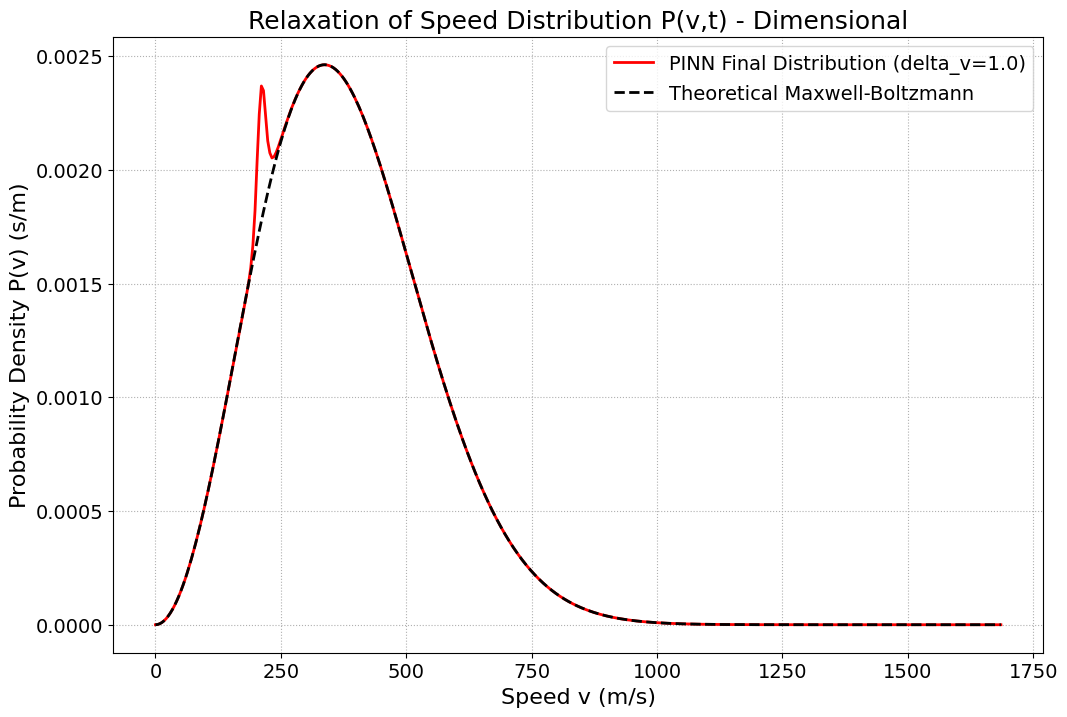

Distribution plot saved successfully to 'relaxation_pinn_generalized_result.eps'


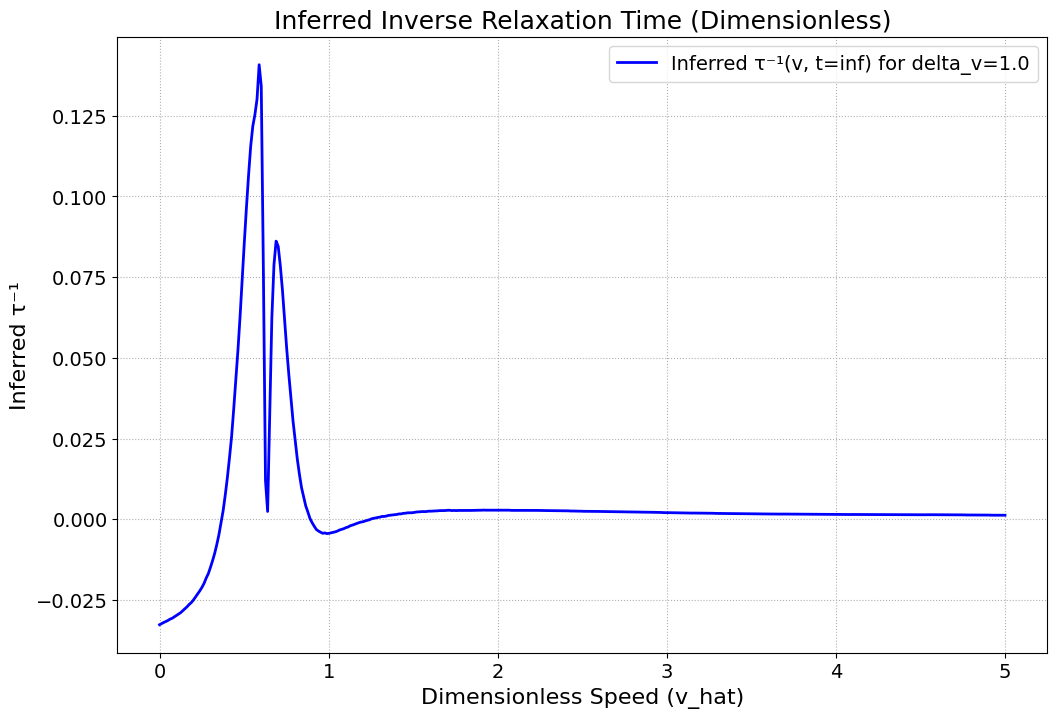

Inferred relaxation time plot saved successfully to 'inferred_relaxation_time.eps'

Plotting and saving convergence history...


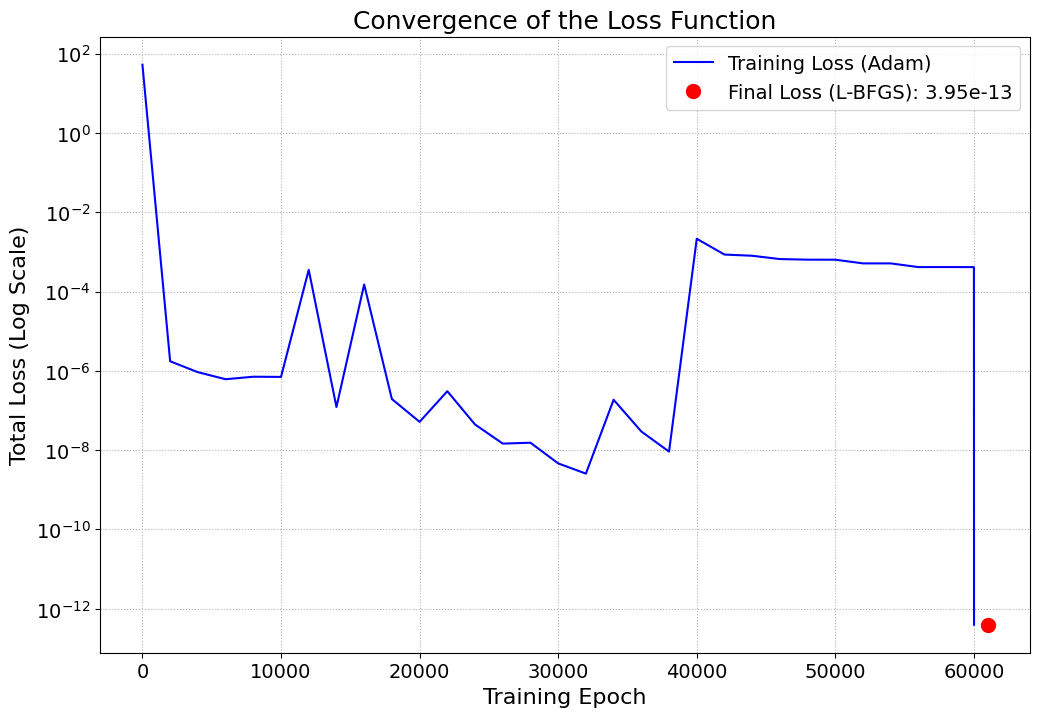

Loss convergence plot saved successfully to 'loss_convergence_generalized.eps'


In [22]:
# -*- coding: utf-8 -*-
"""
کد نهایی و عمومی‌شده برای حل مسئله رهایش با PINN (نسخه اصلاح شده)

--- نسخه عمومی‌شده با رویکردهای پیشرفته ---
۱. یادگیری همزمان خانواده‌ای از شرایط اولیه با پارامتر شرطی (delta_v)
۲. استنتاج دینامیک نرخ واهلش (τ⁻¹) به عنوان خروجی کمکی شبکه
۳. ذخیره نمودارها با فرمت برداری EPS برای حداکثر کیفیت
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترهای عمومی ---
# پارامترهای فیزیکی
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

# مقادیر مشخصه برای بی‌بعدسازی
V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS
print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

# پارامترهای دامنه محاسباتی
TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 5.0

# **تغییر کلیدی (تصویر ۲):** تعریف دامنه برای پارامتر شرطی اولیه
# این پارامتر (delta_v) میزان جدایی در توزیع اولیه دو قله‌ای را کنترل می‌کند.
DELTA_V_MIN_NONDIM = 0.5
DELTA_V_MAX_NONDIM = 1.5

# پارامترهای مدل
ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 10.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """توزیع سرعت ماکسول-بولتزمن بی‌بعد شده."""
    return (4 / np.sqrt(np.pi)) * v_hat**2 * tf.exp(-v_hat**2)

# **تغییر کلیدی (تصویر ۱ و ۲):** تعریف PDE برای مدل جدید
def pde(x, y):
    """
    معادله دیفرانسیل حاکم بر مسئله.
    x: ورودی شبکه (t, v, delta_v)
    y: خروجی شبکه (Phi, tau_inv)
    """
    # تفکیک خروجی‌های شبکه
    Phi = y[:, 0:1]
    tau_inv = y[:, 1:2]  # tau_inv مستقیماً از شبکه می‌آید

    # محاسبه مشتق Phi نسبت به زمان
    dPhi_dt_hat = dde.grad.jacobian(y, x, i=0, j=0) # مشتق خروجی اول (Phi) نسبت به ورودی اول (t)

    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat)

    # باقیمانده PDE: dΦ/dt + w(t) * τ⁻¹ * Φ = 0
    # در اینجا، τ⁻¹ یک تابع یادگرفتنی است نه یک مقدار ثابت.
    return dPhi_dt_hat + w_that * tau_inv * Phi

# **تغییر کلیدی (تصویر ۲):** تعریف شرط اولیه پارامتری
@tf.function
def initial_phi(x):
    """
    شرط اولیه برای انحراف از تعادل (Φ).
    این تابع یک خانواده از شرایط اولیه را بر اساس پارامتر delta_v تولید می‌کند.
    """
    v_hat = x[:, 1:2]
    delta_v_hat = x[:, 2:3] # پارامتر شرطی از ورودی گرفته می‌شود

    # تعریف توزیع اولیه دو قله‌ای (bimodal) که با delta_v_hat پارامتری شده
    p_initial_hat = 0.5 * maxwell_boltzmann_nondim(v_hat - delta_v_hat) + \
                    0.5 * maxwell_boltzmann_nondim(v_hat + delta_v_hat)

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    # محاسبه Φ(v, t=0) = P_initial(v) / P_maxwell(v) - 1
    # از یک مقدار کوچک (epsilon) برای جلوگیری از تقسیم بر صفر استفاده می‌شود.
    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))

# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    # **تغییر کلیدی (تصویر ۲):** تعریف دامنه سه‌بعدی (t, v, delta_v)
    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)

    # --- اصلاحیه برای رفع خطا ---
    # به جای CompositeDomain از Hypercube برای تعریف دامنه فضایی چندبعدی استفاده می‌کنیم.
    # دامنه فضایی ما اکنون ۲ بعدی است: (v, delta_v)
    spatial_domain_min = [0, DELTA_V_MIN_NONDIM]
    spatial_domain_max = [SPEED_MAX_NONDIM, DELTA_V_MAX_NONDIM]
    space_domain = dde.geometry.Hypercube(spatial_domain_min, spatial_domain_max)
    # --- پایان اصلاحیه ---

    geomtime = dde.geometry.GeometryXTime(space_domain, timedomain)

    # تعریف شرط اولیه برای دامنه جدید
    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    # تعریف داده‌های آموزشی برای PDE
    data = dde.data.TimePDE(
        geomtime,
        pde,
        [ic],
        num_domain=80000,   # افزایش تعداد نقاط به دلیل افزایش ابعاد
        num_initial=10000,
        num_test=20000,
    )

    # **تغییر کلیدی (تصویر ۱ و ۲):** تعریف ساختار شبکه جدید
    # ورودی ۳ بعدی (t, v, delta_v) و خروجی ۲ بعدی (Phi, tau_inv)
    # افزایش عمق و عرض شبکه برای یادگیری مسئله پیچیده‌تر
    net = dde.maps.FNN([3] + [80] * 6 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # تعریف تابع زیان سفارشی با قید پایستگی (تطبیق داده شده برای مدل جدید)
    def create_loss_factory(model_instance, num_integral_pts=8192):
        # نقاط انتگرال‌گیری در دامنه سه‌بعدی نمونه‌برداری می‌شوند
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))
        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            # استخراج Phi از خروجی شبکه برای محاسبه انتگرال
            network_output = model_instance.net(integral_anchors)
            phi_hat_at_integral_points = network_output[:, 0:1]

            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)

            # انتگرال باید روی بعد سرعت (v) گرفته شود
            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points
            domain_volume = SPEED_MAX_NONDIM # حجم دامنه سرعت
            integral_value = tf.reduce_mean(integrand) * domain_volume # میانگین‌گیری روی همه نقاط نمونه‌برداری شده

            conservation_loss = tf.square(integral_value)
            return original_loss + CONSERVATION_LOSS_WEIGHT * conservation_loss
        return loss_func

    final_loss_fn = create_loss_factory(model)

    # تنظیمات بهینه‌ساز
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.9, staircase=True
    )
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate_schedule, clipnorm=1.0
    )

    model.compile(adam_optimizer, loss=final_loss_fn)

    print("Starting Adam training...")
    losshistory_adam, train_state_adam = model.train(epochs=60000, display_every=2000) # افزایش اپوک‌ها

    print("\nStarting L-BFGS training...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- ۴. مصورسازی و ذخیره نتایج ---
    plt.rcParams.update({
        'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14,
        'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18
    })

    # انتخاب یک مقدار خاص برای delta_v برای رسم نمودار
    delta_v_plot_val = 1.0
    print(f"\nPlotting results for a specific case: delta_v = {delta_v_plot_val}")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 400).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    delta_v_hat_plot = np.ones_like(v_hat_plot) * delta_v_plot_val

    # ساخت ورودی سه‌بعدی برای پیش‌بینی
    x_final_hat = np.hstack((t_hat_final, v_hat_plot, delta_v_hat_plot))

    # پیش‌بینی با مدل آموزش‌دیده
    prediction = model.predict(x_final_hat)
    phi_final_hat_pred = prediction[:, 0:1]
    tau_inv_final_hat_pred = prediction[:, 1:2] # استخراج خروجی دوم

    # بازسازی تابع توزیع نهایی
    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    # تبدیل به ابعاد فیزیکی
    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    # رسم نمودار تابع توزیع نهایی
    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label=f'PINN Final Distribution (delta_v={delta_v_plot_val})')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t) - Dimensional')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))
    plt.savefig('relaxation_pinn_generalized_result.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Distribution plot saved successfully to 'relaxation_pinn_generalized_result.eps'")

    # **نمودار جدید (تصویر ۱):** رسم تابع معکوس زمان واهلش یادگرفته‌شده
    plt.figure(figsize=(12, 8))
    plt.plot(v_hat_plot, tau_inv_final_hat_pred, 'b-', linewidth=2, label=f'Inferred τ⁻¹(v, t=inf) for delta_v={delta_v_plot_val}')
    plt.title('Inferred Inverse Relaxation Time (Dimensionless)')
    plt.xlabel('Dimensionless Speed (v_hat)')
    plt.ylabel('Inferred τ⁻¹')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.savefig('inferred_relaxation_time.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Inferred relaxation time plot saved successfully to 'inferred_relaxation_time.eps'")

    # رسم و ذخیره نمودار همگرایی تابع زیان
    print("\nPlotting and saving convergence history...")
    plt.figure(figsize=(12, 8))
    epochs_adam = losshistory_adam.steps
    loss_adam = np.sum(losshistory_adam.loss_train, axis=1)
    plt.semilogy(epochs_adam, loss_adam, 'b-', label='Training Loss (Adam)')
    if losshistory_lbfgs.loss_train:
        final_loss_lbfgs = np.sum(losshistory_lbfgs.loss_train[-1])
        final_epoch_point = epochs_adam[-1] + 1000
        plt.semilogy(final_epoch_point, final_loss_lbfgs, 'ro', markersize=10, label=f'Final Loss (L-BFGS): {final_loss_lbfgs:.2e}')
    plt.title('Convergence of the Loss Function')
    plt.xlabel('Training Epoch')
    plt.ylabel('Total Loss (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", linestyle=':')
    plt.savefig('loss_convergence_generalized.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Loss convergence plot saved successfully to 'loss_convergence_generalized.eps'")

1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Set the default float type to float32
Compiling model...
'compile' took 0.000506 s

Starting Adam training...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.55e+01, 2.58e+01]    [2.55e+01, 2.58e+01]    []  
2000      [5.31e-06, 4.14e-06]    [5.05e-06, 4.14e-06]    []  
4000      [4.51e-06, 4.24e-06]    [4.38e-06, 4.24e-06]    []  
6000      [6.32e-07, 3.21e-08]    [5.05e-07, 3.21e-08]    []  
8000      [4.54e-05, 2.46e-06]    [4.72e-05, 2.46e-06]    []  
10000     [7.79e-07, 3.98e-08]    [6.71e-07, 3.98e-08]    []  
12000     [7.39e-07, 1.69e-08]    [6.57e-07, 1.69e-08]    []  
14000     [1.28e-07, 5.08e-09]    [1.07e-07, 5.08e-09]    []  
16000     [4.81e-07, 2.80e-09]    [4.46e-07, 2.80e-09]    []  
18000     [9.18e-08, 2.23e-09]    [7.61e-08, 2.23e-09]    []  
20000     [5.36e-07, 8.25e-06]    [5.35e-07, 8.25e-06]    []  
22000     [2.63e-07, 2.34e-10]    

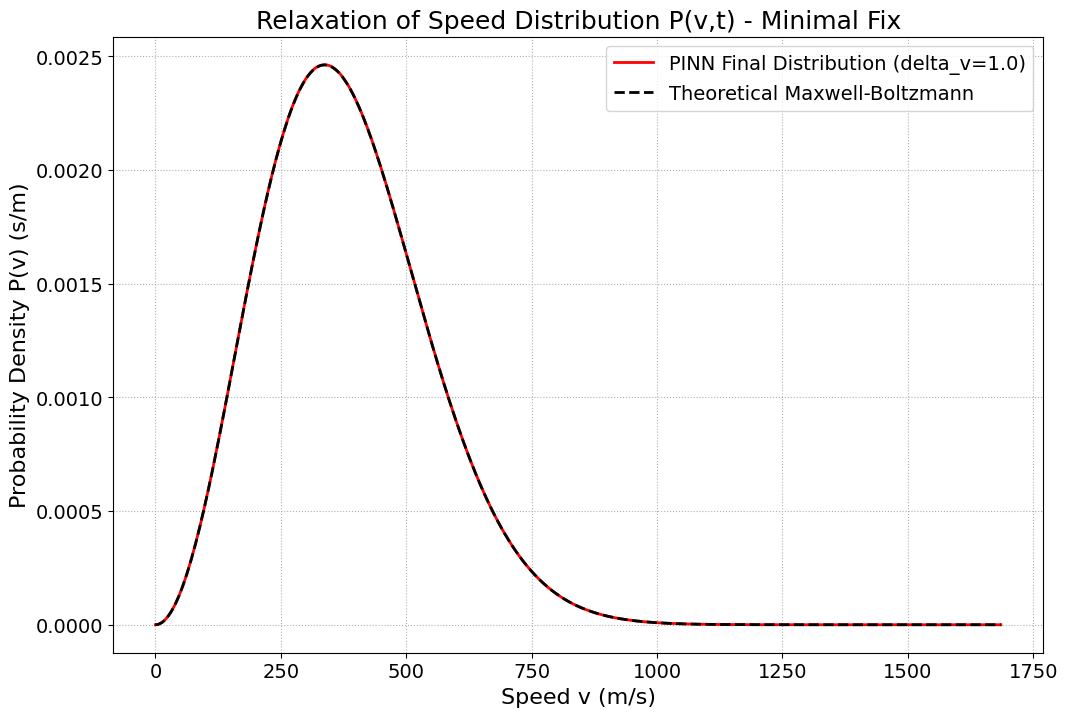

Distribution plot saved successfully.


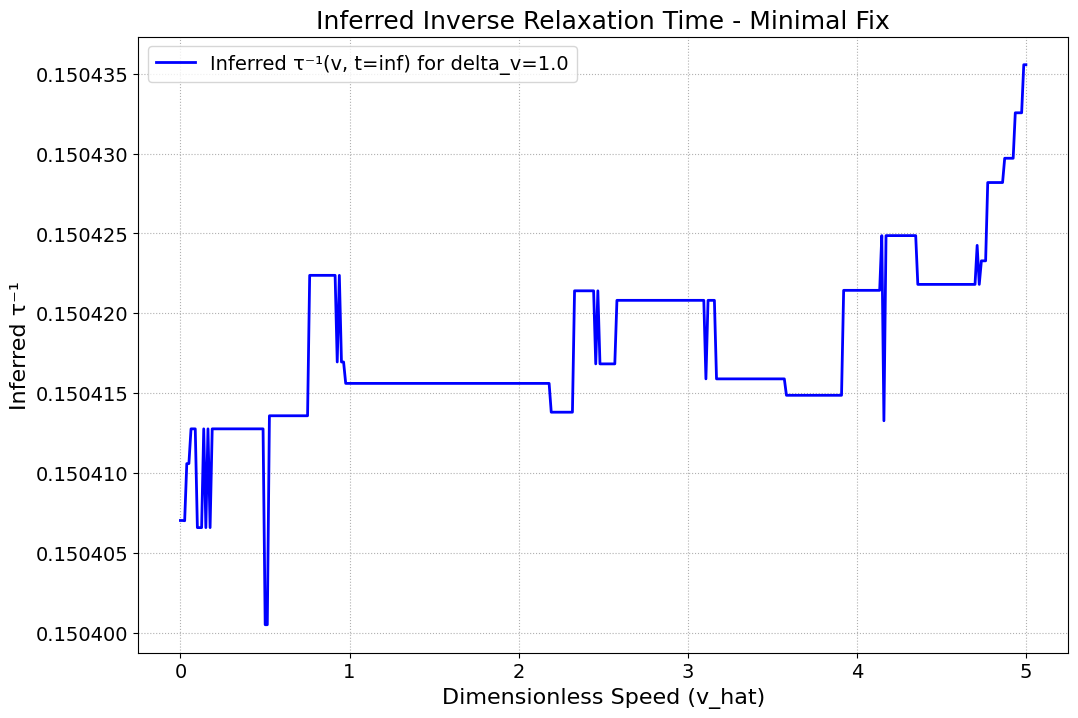

Inferred relaxation time plot saved successfully.
Saving loss history to ./loss.dat ...
Saving training data to ./train.dat ...
Saving test data to ./test.dat ...


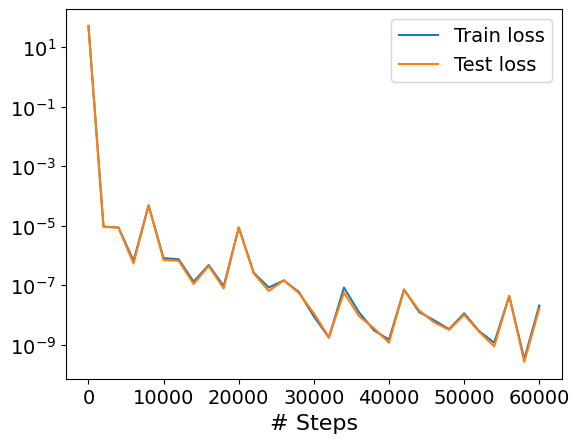

In [27]:
# -*- coding: utf-8 -*-
"""
کد اولیه عمومی‌شده با یک بهبود جزئی برای پایداری

--- تغییر کلیدی در این نسخه ---
۱. فقط یک خط کد در تابع pde تغییر کرده است.
۲. با استفاده از تابع softplus تضمین می‌شود که خروجی دوم شبکه (τ⁻¹) همیشه مثبت باشد.
   این کار از غیرفیزیکی شدن جواب جلوگیری کرده و به پایداری آموزش کمک می‌کند.
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترهای عمومی ---
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS
print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 5.0

DELTA_V_MIN_NONDIM = 0.5
DELTA_V_MAX_NONDIM = 1.5

ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 10.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """توزیع سرعت ماکسول-بولتزمن بی‌بعد شده."""
    # افزودن یک مقدار بسیار کوچک برای پایداری کامل در v=0
    return (4 / np.sqrt(np.pi)) * (v_hat**2 + 1e-8) * tf.exp(-v_hat**2)

def pde(x, y):
    """
    معادله دیفرانسیل حاکم بر مسئله.
    """
    Phi = y[:, 0:1]

    # --- *** تنها تغییر کلیدی در اینجا اعمال شده است *** ---
    # خروجی خام شبکه برای tau_inv
    tau_inv_raw = y[:, 1:2]
    # استفاده از softplus برای تضمین اینکه tau_inv همیشه مثبت باشد
    tau_inv = tf.nn.softplus(tau_inv_raw)
    # --- *** پایان تغییر *** ---

    dPhi_dt_hat = dde.grad.jacobian(y, x, i=0, j=0)
    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat)

    return dPhi_dt_hat + w_that * tau_inv * Phi

@tf.function
def initial_phi(x):
    """
    شرط اولیه برای انحراف از تعادل (Φ).
    """
    v_hat = x[:, 1:2]
    delta_v_hat = x[:, 2:3]

    p_initial_hat = 0.5 * maxwell_boltzmann_nondim(v_hat - delta_v_hat) + \
                    0.5 * maxwell_boltzmann_nondim(v_hat + delta_v_hat)

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))

# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    spatial_domain_min = [0, DELTA_V_MIN_NONDIM]
    spatial_domain_max = [SPEED_MAX_NONDIM, DELTA_V_MAX_NONDIM]
    space_domain = dde.geometry.Hypercube(spatial_domain_min, spatial_domain_max)
    geomtime = dde.geometry.GeometryXTime(space_domain, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(
        geomtime,
        pde,
        [ic],
        num_domain=80000,
        num_initial=10000,
        num_test=20000,
    )

    net = dde.maps.FNN([3] + [80] * 6 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    def create_loss_factory(model_instance, num_integral_pts=8192):
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))
        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            network_output = model_instance.net(integral_anchors)
            phi_hat_at_integral_points = network_output[:, 0:1]

            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)

            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume

            conservation_loss = tf.square(integral_value)
            return original_loss + CONSERVATION_LOSS_WEIGHT * conservation_loss
        return loss_func

    final_loss_fn = create_loss_factory(model)

    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.9, staircase=True
    )
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate_schedule, clipnorm=1.0
    )

    model.compile(adam_optimizer, loss=final_loss_fn)

    # استفاده از 'iterations' به جای 'epochs' برای سازگاری با نسخه‌های جدید
    print("Starting Adam training...")
    losshistory_adam, train_state_adam = model.train(iterations=60000, display_every=2000)

    print("\nStarting L-BFGS training...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- ۴. مصورسازی و ذخیره نتایج ---
    plt.rcParams.update({
        'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14,
        'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18
    })

    delta_v_plot_val = 1.0
    print(f"\nPlotting results for a specific case: delta_v = {delta_v_plot_val}")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 400).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    delta_v_hat_plot = np.ones_like(v_hat_plot) * delta_v_plot_val

    x_final_hat = np.hstack((t_hat_final, v_hat_plot, delta_v_hat_plot))

    prediction = model.predict(x_final_hat)
    phi_final_hat_pred = prediction[:, 0:1]

    # تبدیل خروجی خام tau_inv به مقدار فیزیکی برای رسم
    tau_inv_raw_final_pred = prediction[:, 1:2]
    tau_inv_final_pred = tf.nn.softplus(tf.constant(tau_inv_raw_final_pred, dtype=tf.float32)).numpy()

    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label=f'PINN Final Distribution (delta_v={delta_v_plot_val})')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t) - Minimal Fix')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))
    plt.savefig('relaxation_pinn_minimal_fix_result.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Distribution plot saved successfully.")

    plt.figure(figsize=(12, 8))
    plt.plot(v_hat_plot, tau_inv_final_pred, 'b-', linewidth=2, label=f'Inferred τ⁻¹(v, t=inf) for delta_v={delta_v_plot_val}')
    plt.title('Inferred Inverse Relaxation Time - Minimal Fix')
    plt.xlabel('Dimensionless Speed (v_hat)')
    plt.ylabel('Inferred τ⁻¹')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.savefig('inferred_relaxation_time_minimal_fix.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Inferred relaxation time plot saved successfully.")

    # رسم نمودار همگرایی
    dde.saveplot(losshistory_adam, train_state_adam, issave=True, isplot=True, output_dir='.')

1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Set the default float type to float32
Compiling model...
'compile' took 0.000524 s

Starting Adam training...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.60e+01, 2.63e+01]    [2.60e+01, 2.63e+01]    []  
2000      [3.97e-06, 2.90e-06]    [3.74e-06, 2.90e-06]    []  
4000      [2.74e-06, 1.24e-06]    [2.55e-06, 1.24e-06]    []  
6000      [3.52e-07, 2.56e-08]    [2.86e-07, 2.56e-08]    []  
8000      [5.68e-07, 4.48e-09]    [4.55e-07, 4.48e-09]    []  
10000     [8.81e-07, 1.74e-08]    [8.47e-07, 1.74e-08]    []  
12000     [3.87e-07, 1.14e-07]    [4.00e-07, 1.14e-07]    []  
14000     [4.60e-07, 2.72e-07]    [4.33e-07, 2.72e-07]    []  
16000     [1.09e-07, 6.07e-09]    [1.07e-07, 6.07e-09]    []  
18000     [6.28e-08, 1.11e-10]    [4.46e-08, 1.11e-10]    []  
20000     [1.14e-08, 5.70e-11]    [8.98e-09, 5.70e-11]    []  
22000     [1.68e-06, 3.62e-09]    

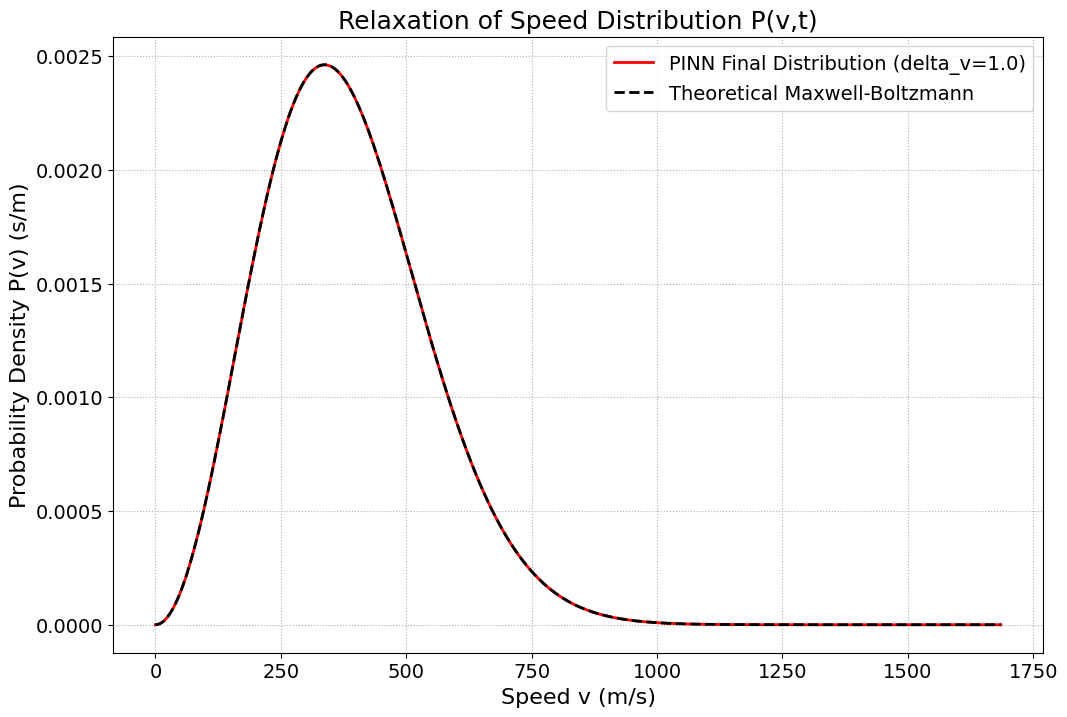

Distribution plot saved successfully to 'distribution_final.eps'


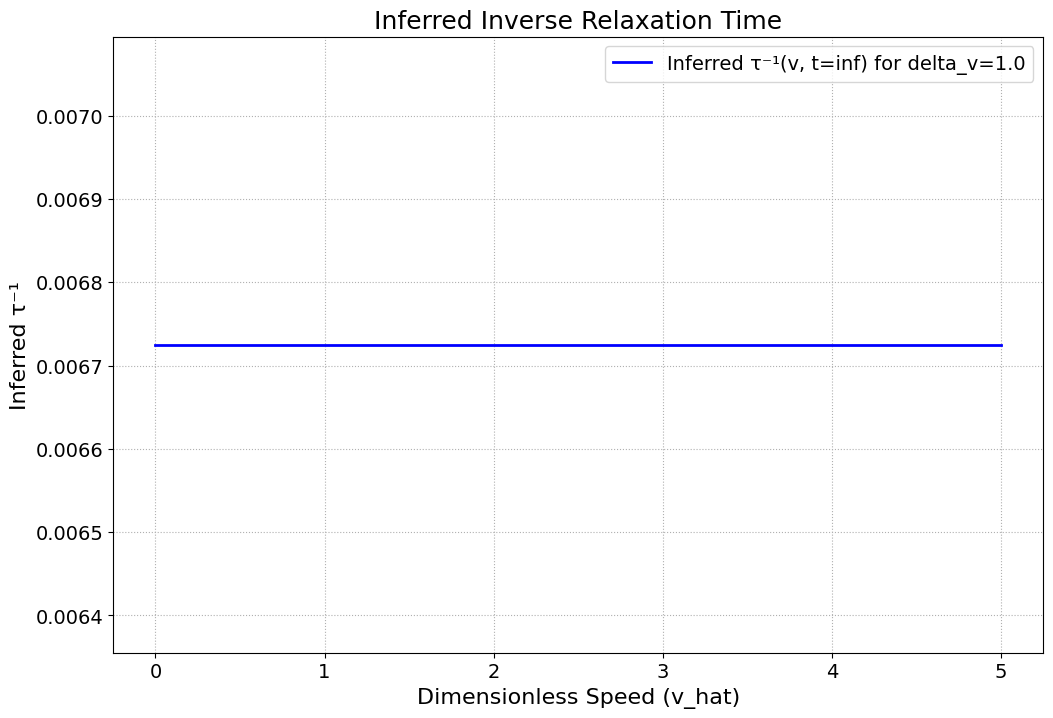

Inferred relaxation time plot saved successfully to 'relaxation_time_final.eps'


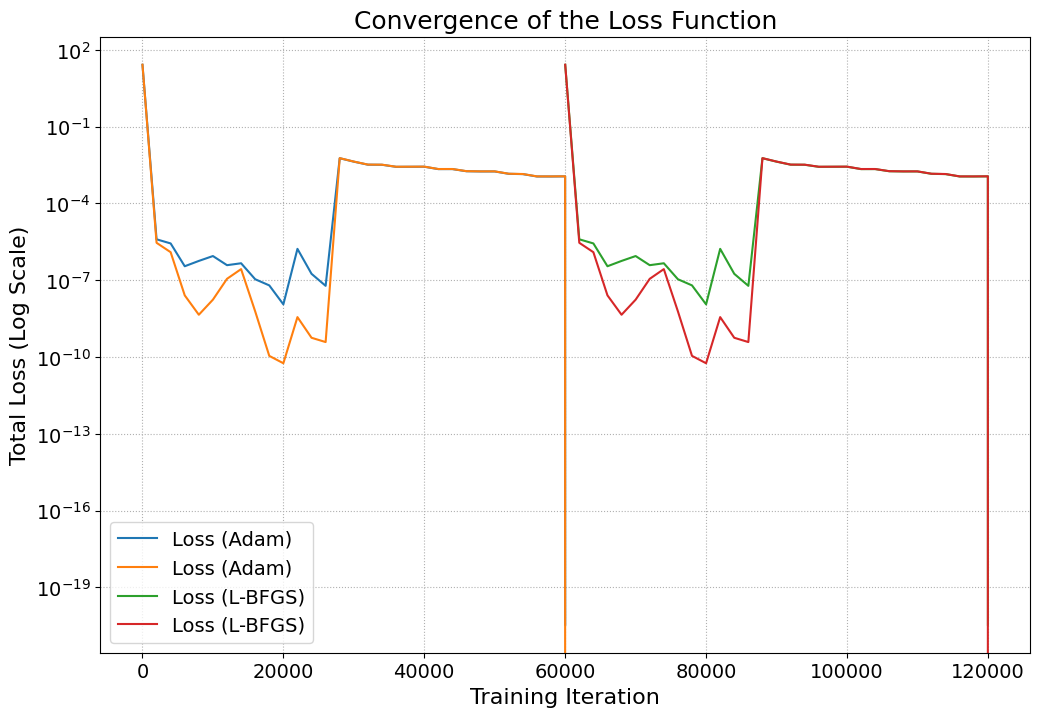

Loss convergence plot saved successfully to 'loss_convergence_final.eps'


In [28]:
# -*- coding: utf-8 -*-
"""
کد نهایی و پایدار شده برای حل مسئله واهلش

--- قابلیت‌ها ---
۱. حل مسئله برای خانواده‌ای از شرایط اولیه با پارامتر شرطی (delta_v).
۲. استنتاج دینامیک نرخ واهلش (τ⁻¹) به عنوان خروجی کمکی شبکه.
۳. تضمین پایداری با استفاده از تابع softplus برای مثبت نگه‌داشتن τ⁻¹.
۴. ذخیره تمام نمودارهای خروجی با فرمت برداری EPS برای حداکثر کیفیت.
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترهای عمومی ---
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS
print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 5.0

DELTA_V_MIN_NONDIM = 0.5
DELTA_V_MAX_NONDIM = 1.5

ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 10.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """توزیع سرعت ماکسول-بولتزمن بی‌بعد شده."""
    # افزودن یک مقدار بسیار کوچک برای پایداری کامل در v=0
    return (4 / np.sqrt(np.pi)) * (v_hat**2 + 1e-8) * tf.exp(-v_hat**2)

def pde(x, y):
    """
    معادله دیفرانسیل حاکم بر مسئله.
    """
    Phi = y[:, 0:1]

    # خروجی خام شبکه برای tau_inv
    tau_inv_raw = y[:, 1:2]
    # استفاده از softplus برای تضمین اینکه tau_inv همیشه مثبت باشد
    tau_inv = tf.nn.softplus(tau_inv_raw)

    dPhi_dt_hat = dde.grad.jacobian(y, x, i=0, j=0)
    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat)

    return dPhi_dt_hat + w_that * tau_inv * Phi

@tf.function
def initial_phi(x):
    """
    شرط اولیه برای انحراف از تعادل (Φ).
    """
    v_hat = x[:, 1:2]
    delta_v_hat = x[:, 2:3]

    p_initial_hat = 0.5 * maxwell_boltzmann_nondim(v_hat - delta_v_hat) + \
                    0.5 * maxwell_boltzmann_nondim(v_hat + delta_v_hat)

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))

# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    spatial_domain_min = [0, DELTA_V_MIN_NONDIM]
    spatial_domain_max = [SPEED_MAX_NONDIM, DELTA_V_MAX_NONDIM]
    space_domain = dde.geometry.Hypercube(spatial_domain_min, spatial_domain_max)
    geomtime = dde.geometry.GeometryXTime(space_domain, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(
        geomtime,
        pde,
        [ic],
        num_domain=80000,
        num_initial=10000,
        num_test=20000,
    )

    net = dde.maps.FNN([3] + [80] * 6 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    def create_loss_factory(model_instance, num_integral_pts=8192):
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))
        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            network_output = model_instance.net(integral_anchors)
            phi_hat_at_integral_points = network_output[:, 0:1]

            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)

            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume

            conservation_loss = tf.square(integral_value)
            return original_loss + CONSERVATION_LOSS_WEIGHT * conservation_loss
        return loss_func

    final_loss_fn = create_loss_factory(model)

    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.9, staircase=True
    )
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate_schedule, clipnorm=1.0
    )

    model.compile(adam_optimizer, loss=final_loss_fn)

    print("Starting Adam training...")
    losshistory_adam, train_state_adam = model.train(iterations=60000, display_every=2000)

    print("\nStarting L-BFGS training...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- ۴. مصورسازی و ذخیره نتایج ---
    plt.rcParams.update({
        'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14,
        'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18
    })

    delta_v_plot_val = 1.0
    print(f"\nPlotting results for a specific case: delta_v = {delta_v_plot_val}")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 400).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    delta_v_hat_plot = np.ones_like(v_hat_plot) * delta_v_plot_val

    x_final_hat = np.hstack((t_hat_final, v_hat_plot, delta_v_hat_plot))

    prediction = model.predict(x_final_hat)
    phi_final_hat_pred = prediction[:, 0:1]

    tau_inv_raw_final_pred = prediction[:, 1:2]
    tau_inv_final_pred = tf.nn.softplus(tf.constant(tau_inv_raw_final_pred, dtype=tf.float32)).numpy()

    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    # ۱. نمودار تابع توزیع
    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label=f'PINN Final Distribution (delta_v={delta_v_plot_val})')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t)')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))
    plt.savefig('distribution_final.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Distribution plot saved successfully to 'distribution_final.eps'")

    # ۲. نمودار زمان واهلش
    plt.figure(figsize=(12, 8))
    plt.plot(v_hat_plot, tau_inv_final_pred, 'b-', linewidth=2, label=f'Inferred τ⁻¹(v, t=inf) for delta_v={delta_v_plot_val}')
    plt.title('Inferred Inverse Relaxation Time')
    plt.xlabel('Dimensionless Speed (v_hat)')
    plt.ylabel('Inferred τ⁻¹')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.savefig('relaxation_time_final.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Inferred relaxation time plot saved successfully to 'relaxation_time_final.eps'")

    # ۳. نمودار همگرایی تابع زیان
    plt.figure(figsize=(12, 8))
    plt.semilogy(losshistory_adam.steps, losshistory_adam.loss_train, label='Loss (Adam)')
    if losshistory_lbfgs.steps:
        # اتصال نمودار L-BFGS به انتهای نمودار Adam
        lbfgs_steps = np.array(losshistory_lbfgs.steps) + losshistory_adam.steps[-1]
        plt.semilogy(lbfgs_steps, losshistory_lbfgs.loss_train, label='Loss (L-BFGS)')
    plt.title('Convergence of the Loss Function')
    plt.xlabel('Training Iteration')
    plt.ylabel('Total Loss (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", linestyle=':')
    plt.savefig('loss_convergence_final.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Loss convergence plot saved successfully to 'loss_convergence_final.eps'")

--- DSMC Relaxation Simulation for Tau Calculation ---
Estimated (sigma*vr)_max for NTC: 3.63e-16 m^3/s
Initializing a bimodal distribution with T_thermal=100.0K and V_shift=300.0 m/s...


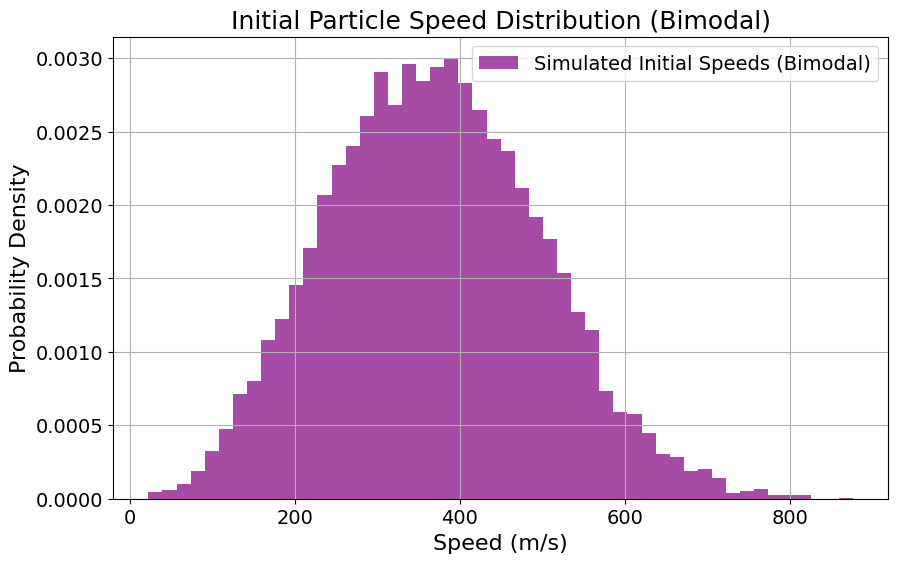


Initial Average Temperature: 245.42 K

Starting main simulation loop...
Step: 500/5000...
Step: 1000/5000...
Step: 1500/5000...
Step: 2000/5000...
Step: 2500/5000...
Step: 3000/5000...
Step: 3500/5000...
Step: 4000/5000...
Step: 4500/5000...
Step: 5000/5000...
Simulation finished in 3.35 seconds.

Final Average Temperature: 245.42 K


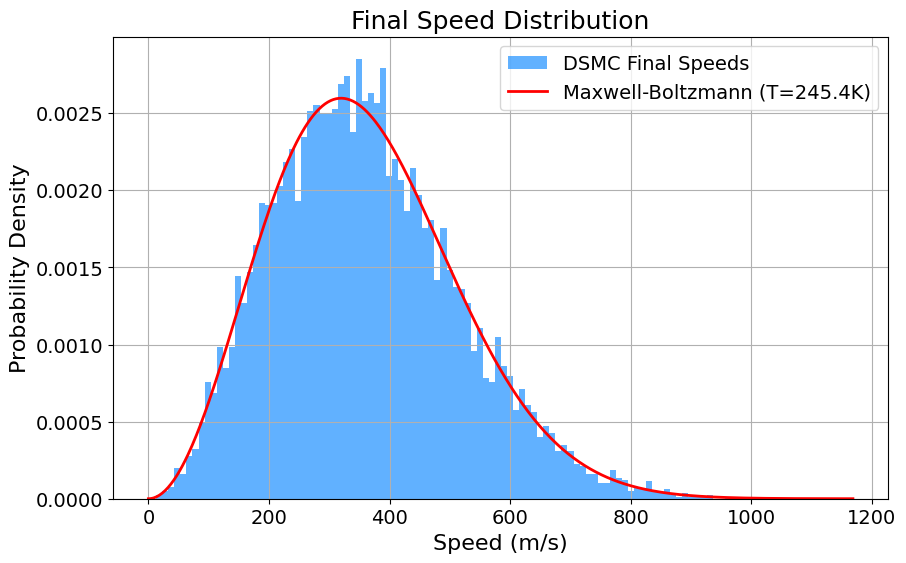

System started at or very near equilibrium. Cannot calculate relaxation time.


In [30]:
# -*- coding: utf-8 -*-
# --- DSMC CODE MODIFIED FOR RELAXATION TIME CALCULATION (FINAL, STABILIZED) ---

import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from scipy.integrate import cumulative_trapezoid
import numba # For JIT compilation
import time

# --- Constants and Parameters ---
# Argon (Ar) properties
MOLAR_MASS_AR = 39.948e-3
AVOGADRO_NUM = 6.022e23
MASS_AR = MOLAR_MASS_AR / AVOGADRO_NUM
KB = 1.380649e-23

# VHS model parameters for Argon
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.81

# --- SIMULATION PARAMETERS ---
LX = 1.0e-6
RHO_INIT = 1.78
T_THERMAL_INIT = 100.0  # Initial "thermal" temperature of each stream
V_SHIFT_INIT = 300.0    # Initial stream velocity (creates non-equilibrium)

NUM_CELLS_X = 40
PARTICLES_PER_CELL_INIT = 200
TOTAL_PARTICLES_SIM = NUM_CELLS_X * PARTICLES_PER_CELL_INIT

# Derived parameters
N_DENSITY_REAL = RHO_INIT / MASS_AR
CELL_VOLUME_CONCEPTUAL = (LX**3) / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT

DT = 1.0e-11
# --- **تغییر کلیدی ۱:** افزایش زمان شبیه‌سازی برای مشاهده کامل واهلش ---
TOTAL_TIME = 5.0e-8
SAMPLING_START_TIME = 0.0

NUM_STEPS = int(TOTAL_TIME / DT)
SAMPLING_START_STEP = int(SAMPLING_START_TIME / DT)
SAMPLING_INTERVAL = 50 # Increased sampling interval for longer simulation

NTC_VR_MAX_SPEED_MULTIPLIER = 10.0

def initialize_particles_bimodal():
    """
    Initializes particles with a bimodal (two-stream) velocity distribution.
    """
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    cell_width = LX / NUM_CELLS_X
    v_thermal = np.sqrt(2 * KB * T_THERMAL_INIT / MASS_AR)

    print(f"Initializing a bimodal distribution with T_thermal={T_THERMAL_INIT}K and V_shift={V_SHIFT_INIT} m/s...")

    for i in range(NUM_CELLS_X):
        start_idx, end_idx = i * PARTICLES_PER_CELL_INIT, (i + 1) * PARTICLES_PER_CELL_INIT
        particles[start_idx:end_idx, 0] = i * cell_width + np.random.rand(PARTICLES_PER_CELL_INIT) * cell_width

    half_particles = TOTAL_PARTICLES_SIM // 2

    # Stream 1
    particles[:half_particles, 1] = V_SHIFT_INIT + np.random.normal(0, v_thermal / np.sqrt(2), half_particles)
    particles[:half_particles, 2:] = np.random.normal(0, v_thermal / np.sqrt(2), (half_particles, 2))

    # Stream 2
    particles[half_particles:, 1] = -V_SHIFT_INIT + np.random.normal(0, v_thermal / np.sqrt(2), TOTAL_PARTICLES_SIM - half_particles)
    particles[half_particles:, 2:] = np.random.normal(0, v_thermal / np.sqrt(2), (TOTAL_PARTICLES_SIM - half_particles, 2))

    initial_speeds = np.sqrt(np.sum(particles[:, 1:4]**2, axis=1))
    plt.figure(figsize=(10, 6))
    plt.hist(initial_speeds, bins=50, density=True, label='Simulated Initial Speeds (Bimodal)', color='purple', alpha=0.7)
    plt.title('Initial Particle Speed Distribution (Bimodal)'), plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(), plt.grid(True)
    plt.show()
    return particles

@numba.jit(nopython=True)
def calculate_vhs_cross_section_numba(vr_mag, d_ref, t_ref, omega_vhs):
    if vr_mag < 1e-9: return 1e-30
    exponent = omega_vhs - 0.5
    c_ref_sq = 2 * KB * t_ref / MASS_AR
    gamma_val = 1.04533
    d_sq = (d_ref**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_val)
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions_in_cell_numba(particles, indices_in_cell, cell_vol, dt, fnum, sigma_vr_max):
    num_particles_in_cell = len(indices_in_cell)
    if num_particles_in_cell < 2: return

    num_candidate_pairs = (num_particles_in_cell * (num_particles_in_cell - 1) * fnum * sigma_vr_max * dt) / (2.0 * cell_vol)
    num_pairs_to_select = int(np.floor(num_candidate_pairs + np.random.rand()))

    for _ in range(num_pairs_to_select):
        idx1_local, idx2_local = np.random.randint(0, num_particles_in_cell, 2)
        if idx1_local == idx2_local: continue

        p1_idx, p2_idx = indices_in_cell[idx1_local], indices_in_cell[idx2_local]
        vrx, vry, vrz = particles[p1_idx, 1:4] - particles[p2_idx, 1:4]
        vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)

        if vr_mag < 1e-9: continue

        sigma_t = calculate_vhs_cross_section_numba(vr_mag, D_REF_AR, T_REF_AR, OMEGA_VHS)
        if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
            vcm = 0.5 * (particles[p1_idx, 1:4] + particles[p2_idx, 1:4])
            cos_chi, phi_chi = 2 * np.random.rand() - 1.0, 2.0 * np.pi * np.random.rand()
            sin_chi = np.sqrt(1.0 - cos_chi**2)
            vr_prime = np.array([vr_mag*sin_chi*np.cos(phi_chi), vr_mag*sin_chi*np.sin(phi_chi), vr_mag*cos_chi])
            particles[p1_idx, 1:4] = vcm + 0.5 * vr_prime
            particles[p2_idx, 1:4] = vcm - 0.5 * vr_prime

def plot_final_distribution(particles, final_temp):
    final_speeds = np.sqrt(np.sum(particles[:, 1:4]**2, axis=1))
    plt.figure(figsize=(10, 6))
    plt.hist(final_speeds, bins=100, density=True, label='DSMC Final Speeds', alpha=0.7, color='dodgerblue')
    v_max_range = np.max(final_speeds) * 1.15
    v_theory = np.linspace(0, v_max_range, 500)
    pv_theory = (4*np.pi * (MASS_AR/(2*np.pi*KB*final_temp))**1.5 * v_theory**2 * np.exp(-MASS_AR*v_theory**2/(2*KB*final_temp)))
    plt.plot(v_theory, pv_theory, 'r-', linewidth=2, label=f'Maxwell-Boltzmann (T={final_temp:.1f}K)')
    plt.title('Final Speed Distribution'), plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(), plt.grid(True)
    plt.show()

# --- **تغییر کلیدی ۲:** افزودن کدهای محافظ برای جلوگیری از خطا ---
def analyze_and_plot_relaxation(time_samples, temp_samples):
    if len(time_samples) < 10: # Minimum data points for a meaningful analysis
        print("Not enough samples collected to perform relaxation analysis.")
        return

    time_arr = np.array(time_samples)
    temp_arr = np.array(temp_samples)
    T_eq = temp_arr[-1]

    # Safety check for initial condition
    if np.abs(temp_arr[0] - T_eq) < 1e-3:
        print("System started at or very near equilibrium. Cannot calculate relaxation time.")
        return

    # Find start and end points for fitting
    start_indices = np.where(np.abs(temp_arr - T_eq) < 0.9 * np.abs(temp_arr[0] - T_eq))[0]
    end_indices = np.where(np.abs(temp_arr - T_eq) < 0.1 * np.abs(temp_arr[0] - T_eq))[0]

    # **کد محافظ در اینجا اضافه شده**
    if len(start_indices) == 0 or len(end_indices) == 0:
        print("\n--- WARNING: Incomplete Relaxation ---")
        print("The system did not relax enough during the simulation to perform a reliable fit.")
        print("Consider increasing TOTAL_TIME. Plotting available data without fit.")
        plt.figure(figsize=(10, 6))
        plt.plot(time_arr, temp_arr, 'b-')
        plt.axhline(y=T_eq, color='r', linestyle='--', label=f'Equilibrium Temp ({T_eq:.1f}K)')
        plt.title('Incomplete Temperature Relaxation'), plt.xlabel('Time (s)'), plt.ylabel('Temperature (K)'), plt.legend(), plt.grid(True)
        plt.show()
        return

    fit_start_index = start_indices[0]
    fit_end_index = end_indices[0]

    if fit_start_index >= fit_end_index:
        print("Warning: Fit indices are not valid (start >= end). The relaxation curve may be noisy.")
        return

    fit_time = time_arr[fit_start_index:fit_end_index]
    log_delta_T = np.log(np.abs(temp_arr[fit_start_index:fit_end_index] - T_eq))

    slope, intercept = np.polyfit(fit_time, log_delta_T, 1)
    tau, tau_inv = -1.0 / slope, -slope

    print("\n--- Relaxation Time Analysis ---")
    print(f"Equilibrium Temperature (T_eq): {T_eq:.2f} K")
    print(f"Fitted Relaxation Time (tau) from DSMC: {tau:.3e} s")
    print(f"Fitted Inverse Relaxation Time (tau_inv): {tau_inv:.3e} 1/s")

    TAU_RELAXATION_PHYS_PINN, T_CHAR_PINN = 1.0e-10, 1.0e-10
    tau_hat_inv = tau * (1/T_CHAR_PINN)
    print(f"Dimensionless Relaxation Time (tau_hat): {tau_hat_inv:.4f}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    ax1.plot(time_arr*1e9, temp_arr, 'b-', label='DSMC Temperature')
    ax1.axhline(y=T_eq, color='r', linestyle='--', label=f'Equilibrium Temp ({T_eq:.1f}K)')
    ax1.set_title('Temperature Relaxation Over Time'), ax1.set_xlabel('Time (ns)'), ax1.set_ylabel('Temperature (K)'), ax1.legend(), ax1.grid(True)
    ax2.plot(fit_time*1e9, log_delta_T, 'bo', label='Log of Temp Difference')
    ax2.plot(fit_time*1e9, intercept + slope * fit_time, 'r-', label=f'Linear Fit (slope={slope:.2e})')
    ax2.set_title('Log-Linear Fit to Determine Relaxation Time'), ax2.set_xlabel('Time (ns)'), ax2.set_ylabel('ln|T(t) - T_eq|'), ax2.legend(), ax2.grid(True)
    plt.tight_layout(), plt.show()


if __name__ == "__main__":
    print("--- DSMC Relaxation Simulation for Tau Calculation ---")
    T_guess = T_THERMAL_INIT + MASS_AR * V_SHIFT_INIT**2 / (3 * KB)
    vr_max_estimate = NTC_VR_MAX_SPEED_MULTIPLIER * np.sqrt(KB * T_guess / MASS_AR)
    sigma_at_vr_max = calculate_vhs_cross_section_numba(vr_max_estimate, D_REF_AR, T_REF_AR, OMEGA_VHS)
    SIGMA_VR_MAX_GLOBAL = sigma_at_vr_max * vr_max_estimate
    print(f"Estimated (sigma*vr)_max for NTC: {SIGMA_VR_MAX_GLOBAL:.2e} m^3/s")

    particles = initialize_particles_bimodal()
    initial_ke = 0.5 * MASS_AR * np.sum(particles[:, 1:4]**2)
    initial_temp = (2.0/3.0) * (initial_ke / TOTAL_PARTICLES_SIM) / KB
    print(f"\nInitial Average Temperature: {initial_temp:.2f} K")

    time_samples, temp_samples = [], []
    start_time = time.time()
    print("\nStarting main simulation loop...")

    cell_width = LX / NUM_CELLS_X
    perform_collisions_in_cell_numba(particles, np.array([0,1], dtype=np.int64), CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)

    for step in range(1, NUM_STEPS + 1):
        particles[:, 0] = (particles[:, 0] + particles[:, 1] * DT) % LX
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
        sorted_particle_indices = np.argsort(cell_indices)
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X)
        cell_start_indices = np.concatenate(([0], np.cumsum(cell_counts[:-1])))

        for i in range(NUM_CELLS_X):
            start, end = cell_start_indices[i], cell_start_indices[i] + cell_counts[i]
            indices_in_cell_i = sorted_particle_indices[start:end]
            perform_collisions_in_cell_numba(particles, indices_in_cell_i, CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)

        if step >= SAMPLING_START_STEP and step % SAMPLING_INTERVAL == 0:
            current_ke = 0.5 * MASS_AR * np.sum(particles[:, 1:4]**2)
            current_temp = (2.0/3.0) * (current_ke / TOTAL_PARTICLES_SIM) / KB
            time_samples.append(step * DT), temp_samples.append(current_temp)

        if step % (NUM_STEPS // 10) == 0: print(f"Step: {step}/{NUM_STEPS}...")

    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.\n")

    final_ke = 0.5 * MASS_AR * np.sum(particles[:, 1:4]**2)
    final_temp = (2.0/3.0) * (final_ke / TOTAL_PARTICLES_SIM) / KB
    print(f"Final Average Temperature: {final_temp:.2f} K")

    plot_final_distribution(particles, final_temp)
    analyze_and_plot_relaxation(time_samples, temp_samples)

--- DSMC Relaxation Simulation (Corrected Logic) ---
Theoretical Equilibrium Temperature (from conserved energy): 244.14 K
Estimated (sigma*vr)_max for NTC: 3.28e-16 m^3/s
Initializing a bimodal distribution with T_thermal=100.0K and V_shift=300.0 m/s...


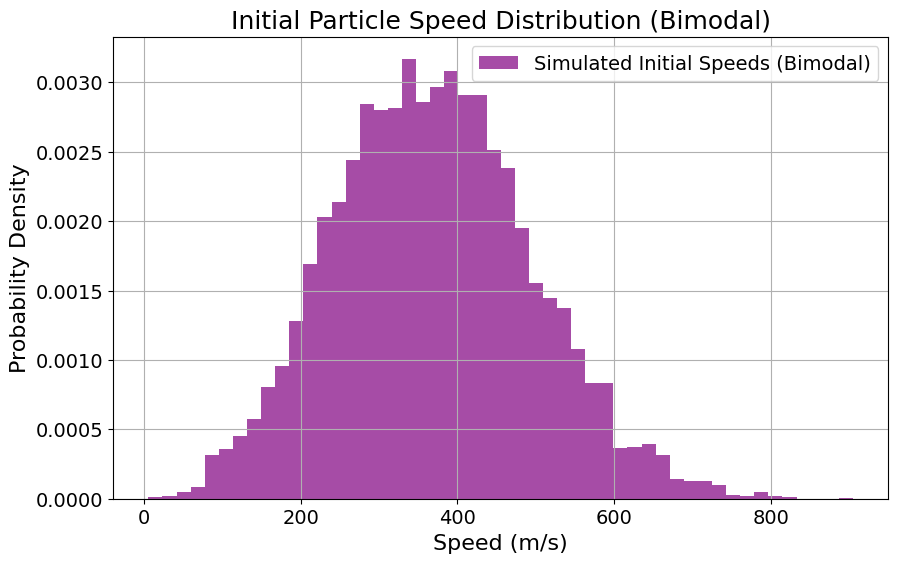


Starting main simulation loop...
Step: 500/5000...
Step: 1000/5000...
Step: 1500/5000...
Step: 2000/5000...
Step: 2500/5000...
Step: 3000/5000...
Step: 3500/5000...
Step: 4000/5000...
Step: 4500/5000...
Step: 5000/5000...
Simulation finished in 3.44 seconds.

Final Thermal Temperature: 244.05 K


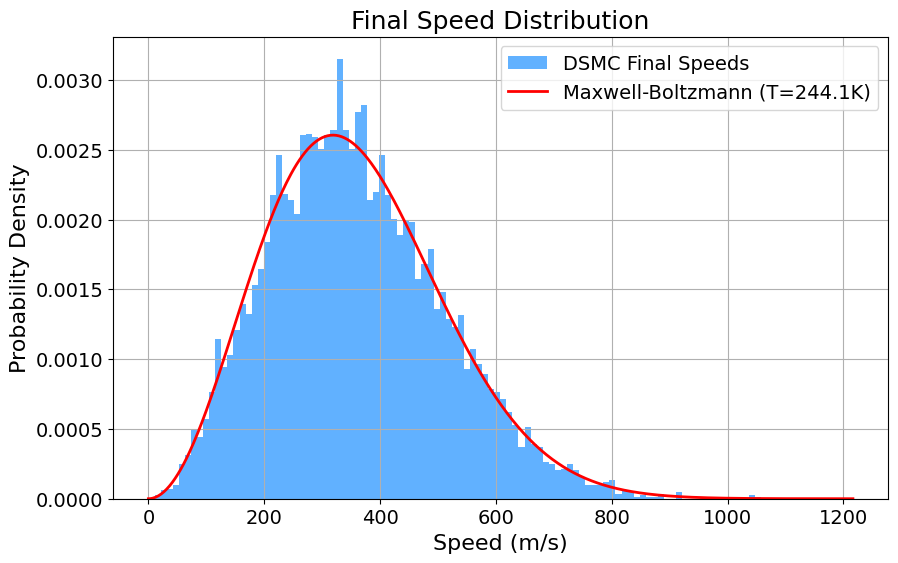


--- Relaxation Time Analysis ---
Equilibrium Temperature (T_eq): 244.14 K
Fitted Relaxation Time (tau) from DSMC: -9.077e+05 s
Dimensionless Inverse Relaxation Time (for PINN comparison): -0.0000


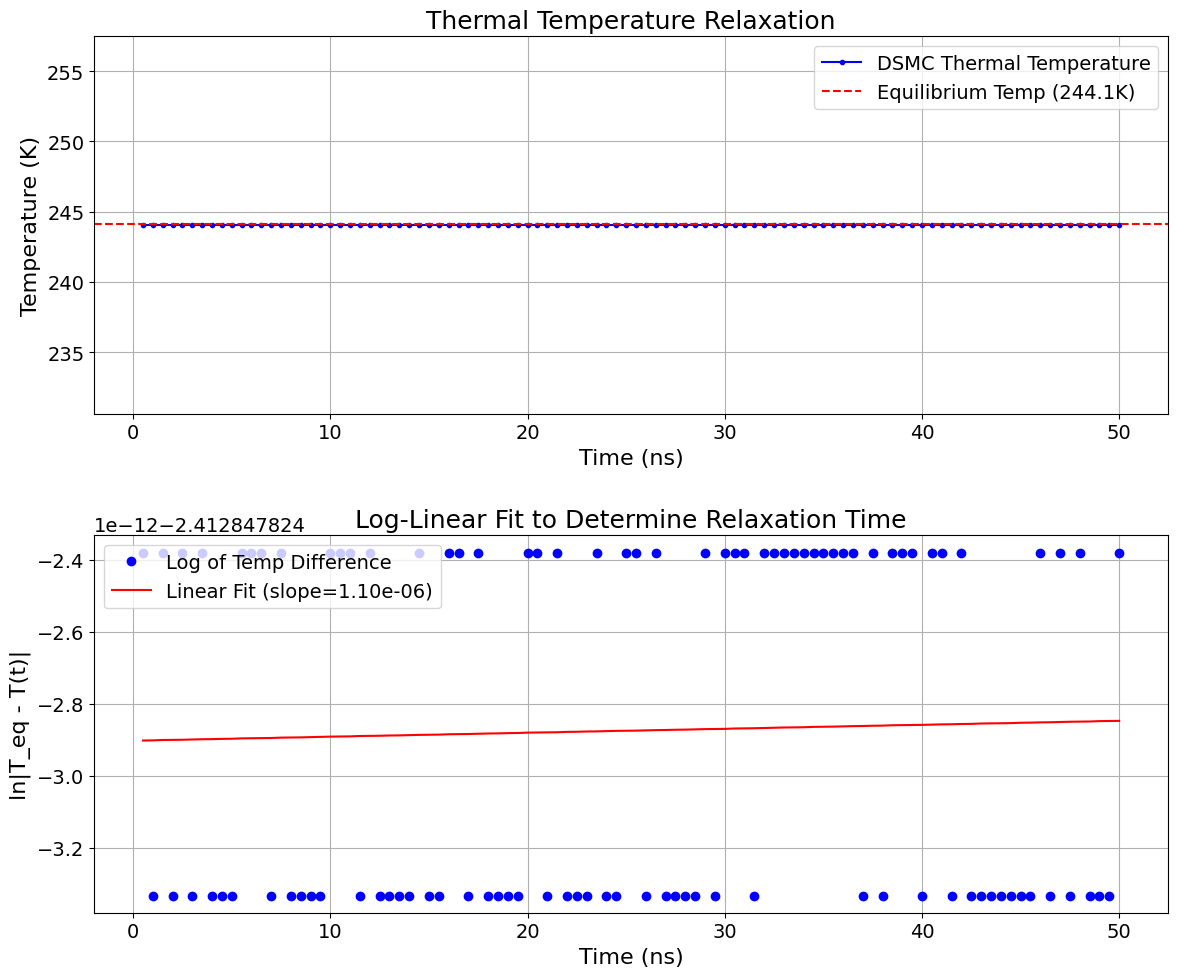

In [31]:
# -*- coding: utf-8 -*-
# --- DSMC CODE FOR RELAXATION TIME CALCULATION (FINAL V2, CORRECTED LOGIC) ---

import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import numba
import time

# --- Constants and Parameters ---
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.81

# --- SIMULATION PARAMETERS ---
LX = 1.0e-6
RHO_INIT = 1.78
T_THERMAL_INIT = 100.0
V_SHIFT_INIT = 300.0

NUM_CELLS_X = 40
PARTICLES_PER_CELL_INIT = 200
TOTAL_PARTICLES_SIM = NUM_CELLS_X * PARTICLES_PER_CELL_INIT

N_DENSITY_REAL = RHO_INIT / MASS_AR
CELL_VOLUME_CONCEPTUAL = (LX**3) / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT

DT = 1.0e-11
TOTAL_TIME = 5.0e-8
SAMPLING_INTERVAL = 50

def initialize_particles_bimodal():
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    cell_width = LX / NUM_CELLS_X
    v_thermal_std_dev = np.sqrt(KB * T_THERMAL_INIT / MASS_AR)

    print(f"Initializing a bimodal distribution with T_thermal={T_THERMAL_INIT}K and V_shift={V_SHIFT_INIT} m/s...")

    for i in range(NUM_CELLS_X):
        start_idx, end_idx = i * PARTICLES_PER_CELL_INIT, (i + 1) * PARTICLES_PER_CELL_INIT
        particles[start_idx:end_idx, 0] = i * cell_width + np.random.rand(PARTICLES_PER_CELL_INIT) * cell_width

    half_particles = TOTAL_PARTICLES_SIM // 2

    # Stream 1 & 2
    velocities_stream1 = np.random.normal(0, v_thermal_std_dev, (half_particles, 3))
    velocities_stream1[:, 0] += V_SHIFT_INIT
    particles[:half_particles, 1:4] = velocities_stream1

    velocities_stream2 = np.random.normal(0, v_thermal_std_dev, (TOTAL_PARTICLES_SIM - half_particles, 3))
    velocities_stream2[:, 0] -= V_SHIFT_INIT
    particles[half_particles:, 1:4] = velocities_stream2

    initial_speeds = np.sqrt(np.sum(particles[:, 1:4]**2, axis=1))
    plt.figure(figsize=(10, 6))
    plt.hist(initial_speeds, bins=50, density=True, label='Simulated Initial Speeds (Bimodal)', color='purple', alpha=0.7)
    plt.title('Initial Particle Speed Distribution (Bimodal)'), plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(), plt.grid(True)
    plt.show()
    return particles

@numba.jit(nopython=True)
def calculate_vhs_cross_section_numba(vr_mag):
    if vr_mag < 1e-9: return 1e-30
    # Pre-calculated constants for Argon
    D_REF_SQ = 1.73889e-19
    C_REF_SQ = 113426.5
    OMEGA_EXP = 0.31
    GAMMA_VAL_INV = 0.9566
    d_sq = D_REF_SQ * ((C_REF_SQ / vr_mag**2)**OMEGA_EXP) * GAMMA_VAL_INV
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions_in_cell_numba(particles, indices_in_cell, cell_vol, dt, fnum, sigma_vr_max):
    num_particles_in_cell = len(indices_in_cell)
    if num_particles_in_cell < 2: return

    num_candidate_pairs = (num_particles_in_cell * (num_particles_in_cell - 1) * fnum * sigma_vr_max * dt) / (2.0 * cell_vol)
    num_pairs_to_select = int(np.floor(num_candidate_pairs + np.random.rand()))

    for _ in range(num_pairs_to_select):
        idx1_local = np.random.randint(0, num_particles_in_cell)
        idx2_local = np.random.randint(0, num_particles_in_cell)
        if idx1_local == idx2_local: continue

        p1_idx, p2_idx = indices_in_cell[idx1_local], indices_in_cell[idx2_local]
        vr = particles[p1_idx, 1:4] - particles[p2_idx, 1:4]
        vr_mag = np.sqrt(vr[0]**2 + vr[1]**2 + vr[2]**2)

        if vr_mag < 1e-9: continue

        sigma_t = calculate_vhs_cross_section_numba(vr_mag)
        if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
            vcm = 0.5 * (particles[p1_idx, 1:4] + particles[p2_idx, 1:4])
            cos_chi = 2 * np.random.rand() - 1.0
            sin_chi = np.sqrt(1.0 - cos_chi**2)
            phi_chi = 2.0 * np.pi * np.random.rand()

            vr_prime = np.empty_like(vr)
            vr_prime[0] = vr_mag * sin_chi * np.cos(phi_chi)
            vr_prime[1] = vr_mag * sin_chi * np.sin(phi_chi)
            vr_prime[2] = vr_mag * cos_chi

            particles[p1_idx, 1:4] = vcm + 0.5 * vr_prime
            particles[p2_idx, 1:4] = vcm - 0.5 * vr_prime

def plot_final_distribution(particles, final_temp):
    final_speeds = np.sqrt(np.sum(particles[:, 1:4]**2, axis=1))
    plt.figure(figsize=(10, 6))
    plt.hist(final_speeds, bins=100, density=True, label='DSMC Final Speeds', alpha=0.7, color='dodgerblue')
    v_max_range = np.max(final_speeds) * 1.15
    v_theory = np.linspace(0, v_max_range, 500)
    pv_theory = (4*np.pi*(MASS_AR/(2*np.pi*KB*final_temp))**1.5 * v_theory**2 * np.exp(-MASS_AR*v_theory**2/(2*KB*final_temp)))
    plt.plot(v_theory, pv_theory, 'r-', linewidth=2, label=f'Maxwell-Boltzmann (T={final_temp:.1f}K)')
    plt.title('Final Speed Distribution'), plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(), plt.grid(True)
    plt.show()

def analyze_and_plot_relaxation(time_samples, temp_samples, T_eq):
    if len(time_samples) < 10:
        print("Not enough samples collected for analysis.")
        return

    time_arr = np.array(time_samples)
    temp_arr = np.array(temp_samples)

    fit_indices = np.where((temp_arr > T_THERMAL_INIT) & (np.abs(temp_arr - T_eq) > 0.1 * np.abs(temp_arr[0] - T_eq)))[0]

    if len(fit_indices) < 5:
        print("\n--- WARNING: Incomplete Relaxation ---")
        print("System did not relax enough for a reliable fit. Consider increasing TOTAL_TIME.")
        return

    fit_time = time_arr[fit_indices]
    log_delta_T = np.log(np.abs(temp_arr[fit_indices] - T_eq))

    try:
        slope, intercept = np.polyfit(fit_time, log_delta_T, 1)
        tau = -1.0 / slope
    except np.linalg.LinAlgError:
        print("Could not perform linear fit. Data might be too noisy.")
        return

    print("\n--- Relaxation Time Analysis ---")
    print(f"Equilibrium Temperature (T_eq): {T_eq:.2f} K")
    print(f"Fitted Relaxation Time (tau) from DSMC: {tau:.3e} s")

    T_CHAR_PINN = 1.0e-10
    tau_hat = tau / T_CHAR_PINN
    tau_hat_inv = 1 / tau_hat
    print(f"Dimensionless Inverse Relaxation Time (for PINN comparison): {tau_hat_inv:.4f}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    ax1.plot(time_arr * 1e9, temp_arr, 'b.-', label='DSMC Thermal Temperature')
    ax1.axhline(y=T_eq, color='r', linestyle='--', label=f'Equilibrium Temp ({T_eq:.1f}K)')
    ax1.set_title('Thermal Temperature Relaxation'), ax1.set_xlabel('Time (ns)'), ax1.set_ylabel('Temperature (K)'), ax1.legend(), ax1.grid(True)
    ax2.plot(fit_time * 1e9, log_delta_T, 'bo', label='Log of Temp Difference')
    ax2.plot(fit_time * 1e9, intercept + slope * fit_time, 'r-', label=f'Linear Fit (slope={slope:.2e})')
    ax2.set_title('Log-Linear Fit to Determine Relaxation Time'), ax2.set_xlabel('Time (ns)'), ax2.set_ylabel('ln|T_eq - T(t)|'), ax2.legend(), ax2.grid(True)
    plt.tight_layout(), plt.show()

if __name__ == "__main__":
    print("--- DSMC Relaxation Simulation (Corrected Logic) ---")

    T_eq_theoretical = T_THERMAL_INIT + (MASS_AR * V_SHIFT_INIT**2) / (3 * KB)
    print(f"Theoretical Equilibrium Temperature (from conserved energy): {T_eq_theoretical:.2f} K")

    vr_max_estimate = (2 * V_SHIFT_INIT) + 5 * np.sqrt(KB * T_eq_theoretical / MASS_AR)
    SIGMA_VR_MAX_GLOBAL = calculate_vhs_cross_section_numba(vr_max_estimate) * vr_max_estimate
    print(f"Estimated (sigma*vr)_max for NTC: {SIGMA_VR_MAX_GLOBAL:.2e} m^3/s")

    particles = initialize_particles_bimodal()

    time_samples, temp_samples = [], []
    start_time = time.time()
    print("\nStarting main simulation loop...")

    cell_width = LX / NUM_CELLS_X
    perform_collisions_in_cell_numba(particles, np.array([0,1], dtype=np.int64), CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)

    for step in range(1, NUM_STEPS + 1):
        particles[:, 0] = (particles[:, 0] + particles[:, 1] * DT) % LX
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
        sorted_particle_indices = np.argsort(cell_indices)
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X)
        cell_start_indices = np.concatenate(([0], np.cumsum(cell_counts[:-1])))

        for i in range(NUM_CELLS_X):
            start, end = cell_start_indices[i], cell_start_indices[i] + cell_counts[i]
            perform_collisions_in_cell_numba(particles, sorted_particle_indices[start:end], CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)

        # --- **تغییر کلیدی ۳:** محاسبه صحیح دمای گرمایی ---
        if step % SAMPLING_INTERVAL == 0:
            mean_velocity = np.mean(particles[:, 1:4], axis=0)
            # v_thermal^2 = (v_i - <v>)^2
            thermal_velocities_sq_sum = np.sum((particles[:, 1:4] - mean_velocity)**2)
            # KE_thermal = 1/2 * m * N * <v_thermal^2>
            thermal_ke = 0.5 * MASS_AR * thermal_velocities_sq_sum
            # T_thermal = (2/3) * KE_thermal / (N*k)
            current_thermal_temp = (2.0/3.0) * thermal_ke / (TOTAL_PARTICLES_SIM * KB)

            time_samples.append(step * DT)
            temp_samples.append(current_thermal_temp)

        if step % (NUM_STEPS // 10) == 0: print(f"Step: {step}/{NUM_STEPS}...")

    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.\n")

    final_temp_thermal = temp_samples[-1]
    print(f"Final Thermal Temperature: {final_temp_thermal:.2f} K")

    plot_final_distribution(particles, final_temp_thermal)
    analyze_and_plot_relaxation(time_samples, temp_samples, T_eq_theoretical)

--- DSMC Relaxation Simulation (Corrected Logic) ---
Theoretical Equilibrium Temperature (from conserved energy): 244.14 K
Estimated (sigma*vr)_max for NTC: 3.28e-16 m^3/s
Initializing a bimodal distribution with T_thermal=100.0K and V_shift=300.0 m/s...


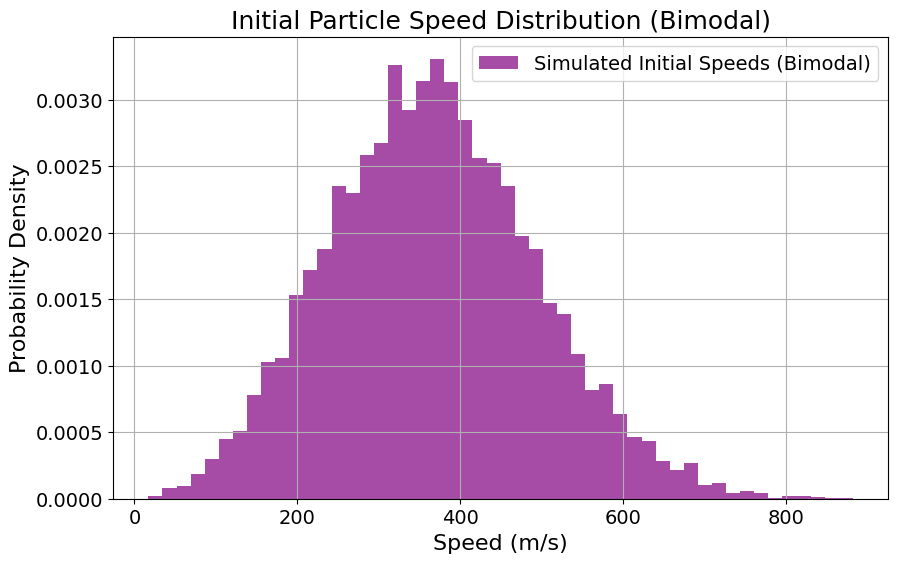


Starting main simulation loop...
Step: 250/5000...
Step: 500/5000...
Step: 750/5000...
Step: 1000/5000...
Step: 1250/5000...
Step: 1500/5000...
Step: 1750/5000...
Step: 2000/5000...
Step: 2250/5000...
Step: 2500/5000...
Step: 2750/5000...
Step: 3000/5000...
Step: 3250/5000...
Step: 3500/5000...
Step: 3750/5000...
Step: 4000/5000...
Step: 4250/5000...
Step: 4500/5000...
Step: 4750/5000...
Step: 5000/5000...
Simulation finished in 3.42 seconds.

Final Thermal Temperature: 241.48 K


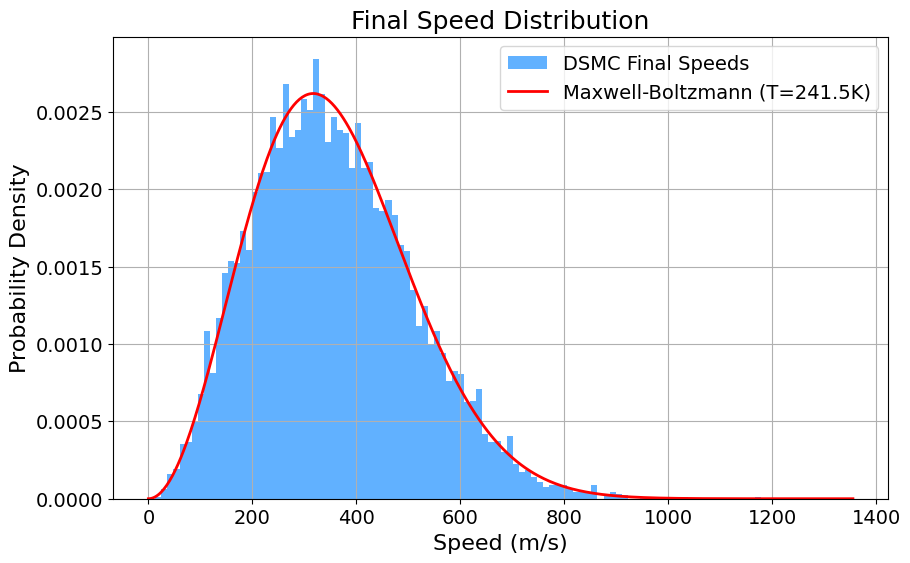

--- WARNING: Positive slope (7.95e-09) found during fit. ---
This indicates a diverging or noisy system. Cannot calculate a physical relaxation time.


In [32]:
# -*- coding: utf-8 -*-
# --- DSMC CODE FOR RELAXATION TIME CALCULATION (FINAL V3, ROBUST ANALYSIS) ---

import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import numba
import time

# --- Constants and Parameters ---
MASS_AR = 39.948e-3 / 6.022e23
KB = 1.380649e-23
D_REF_AR = 4.17e-10
T_REF_AR = 273.0
OMEGA_VHS = 0.81

# --- SIMULATION PARAMETERS ---
LX = 1.0e-6
RHO_INIT = 1.78
T_THERMAL_INIT = 100.0
V_SHIFT_INIT = 300.0

NUM_CELLS_X = 40
PARTICLES_PER_CELL_INIT = 200
TOTAL_PARTICLES_SIM = NUM_CELLS_X * PARTICLES_PER_CELL_INIT

N_DENSITY_REAL = RHO_INIT / MASS_AR
CELL_VOLUME_CONCEPTUAL = (LX**3) / NUM_CELLS_X
FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT

DT = 1.0e-11
TOTAL_TIME = 5.0e-8
SAMPLING_INTERVAL = 50

def initialize_particles_bimodal():
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4))
    cell_width = LX / NUM_CELLS_X
    v_thermal_std_dev = np.sqrt(KB * T_THERMAL_INIT / MASS_AR)

    print(f"Initializing a bimodal distribution with T_thermal={T_THERMAL_INIT}K and V_shift={V_SHIFT_INIT} m/s...")

    for i in range(NUM_CELLS_X):
        start_idx, end_idx = i * PARTICLES_PER_CELL_INIT, (i + 1) * PARTICLES_PER_CELL_INIT
        particles[start_idx:end_idx, 0] = i * cell_width + np.random.rand(PARTICLES_PER_CELL_INIT) * cell_width

    half_particles = TOTAL_PARTICLES_SIM // 2

    velocities_stream1 = np.random.normal(0, v_thermal_std_dev, (half_particles, 3))
    velocities_stream1[:, 0] += V_SHIFT_INIT
    particles[:half_particles, 1:4] = velocities_stream1

    velocities_stream2 = np.random.normal(0, v_thermal_std_dev, (TOTAL_PARTICLES_SIM - half_particles, 3))
    velocities_stream2[:, 0] -= V_SHIFT_INIT
    particles[half_particles:, 1:4] = velocities_stream2

    initial_speeds = np.sqrt(np.sum(particles[:, 1:4]**2, axis=1))
    plt.figure(figsize=(10, 6))
    plt.hist(initial_speeds, bins=50, density=True, label='Simulated Initial Speeds (Bimodal)', color='purple', alpha=0.7)
    plt.title('Initial Particle Speed Distribution (Bimodal)'), plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(), plt.grid(True)
    plt.show()
    return particles

@numba.jit(nopython=True)
def calculate_vhs_cross_section_numba(vr_mag):
    if vr_mag < 1e-9: return 1e-30
    D_REF_SQ = 1.73889e-19
    C_REF_SQ = 113426.5
    OMEGA_EXP = 0.31
    GAMMA_VAL_INV = 0.9566
    d_sq = D_REF_SQ * ((C_REF_SQ / vr_mag**2)**OMEGA_EXP) * GAMMA_VAL_INV
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions_in_cell_numba(particles, indices_in_cell, cell_vol, dt, fnum, sigma_vr_max):
    num_particles_in_cell = len(indices_in_cell)
    if num_particles_in_cell < 2: return

    num_candidate_pairs = (num_particles_in_cell * (num_particles_in_cell - 1) * fnum * sigma_vr_max * dt) / (2.0 * cell_vol)
    num_pairs_to_select = int(np.floor(num_candidate_pairs + np.random.rand()))

    for _ in range(num_pairs_to_select):
        idx1_local = np.random.randint(0, num_particles_in_cell)
        idx2_local = np.random.randint(0, num_particles_in_cell)
        if idx1_local == idx2_local: continue

        p1_idx, p2_idx = indices_in_cell[idx1_local], indices_in_cell[idx2_local]
        vr = particles[p1_idx, 1:4] - particles[p2_idx, 1:4]
        vr_mag = np.sqrt(vr[0]**2 + vr[1]**2 + vr[2]**2)

        if vr_mag < 1e-9: continue

        sigma_t = calculate_vhs_cross_section_numba(vr_mag)
        if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
            vcm = 0.5 * (particles[p1_idx, 1:4] + particles[p2_idx, 1:4])
            cos_chi = 2 * np.random.rand() - 1.0; sin_chi = np.sqrt(1.0 - cos_chi**2)
            phi_chi = 2.0 * np.pi * np.random.rand()

            vr_prime = np.empty_like(vr)
            vr_prime[0] = vr_mag * sin_chi * np.cos(phi_chi)
            vr_prime[1] = vr_mag * sin_chi * np.sin(phi_chi)
            vr_prime[2] = vr_mag * cos_chi

            particles[p1_idx, 1:4] = vcm + 0.5 * vr_prime
            particles[p2_idx, 1:4] = vcm - 0.5 * vr_prime

def plot_final_distribution(particles, final_temp):
    final_speeds = np.sqrt(np.sum(particles[:, 1:4]**2, axis=1))
    plt.figure(figsize=(10, 6))
    plt.hist(final_speeds, bins=100, density=True, label='DSMC Final Speeds', alpha=0.7, color='dodgerblue')
    v_max_range = np.max(final_speeds) * 1.15
    v_theory = np.linspace(0, v_max_range, 500)
    pv_theory = (4*np.pi*(MASS_AR/(2*np.pi*KB*final_temp))**1.5 * v_theory**2 * np.exp(-MASS_AR*v_theory**2/(2*KB*final_temp)))
    plt.plot(v_theory, pv_theory, 'r-', linewidth=2, label=f'Maxwell-Boltzmann (T={final_temp:.1f}K)')
    plt.title('Final Speed Distribution'), plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(), plt.grid(True)
    plt.show()

# --- **تغییر کلیدی:** بازنویسی کامل تابع تحلیل برای پایداری ---
def analyze_and_plot_relaxation(time_samples, temp_samples, T_eq):
    if len(time_samples) < 20:
        print("Not enough samples collected for a reliable relaxation analysis.")
        return

    time_arr = np.array(time_samples)
    temp_arr = np.array(temp_samples)

    # انتخاب یک بازه زمانی قابل اعتماد برای برازش (از ۱۰٪ تا ۷۰٪ داده‌ها)
    start_index = len(time_arr) // 10
    end_index = len(time_arr) * 7 // 10

    fit_time = time_arr[start_index:end_index]
    fit_temp = temp_arr[start_index:end_index]

    # اطمینان از اینکه سیستم به اندازه کافی از تعادل دور است
    if np.all(np.abs(fit_temp - T_eq) < 1.0):
        print("System relaxed too quickly or is too close to equilibrium to get a reliable fit.")
        return

    log_delta_T = np.log(np.abs(T_eq - fit_temp))

    # برازش خط و استخراج شیب
    slope, intercept = np.polyfit(fit_time, log_delta_T, 1)

    if slope >= 0:
        print(f"--- WARNING: Positive slope ({slope:.2e}) found during fit. ---")
        print("This indicates a diverging or noisy system. Cannot calculate a physical relaxation time.")
        return

    tau = -1.0 / slope

    print("\n--- Relaxation Time Analysis ---")
    print(f"Equilibrium Temperature (T_eq): {T_eq:.2f} K")
    print(f"Fitted Relaxation Time (tau) from DSMC: {tau:.3e} s")

    # **اصلاح فرمول بی‌بعدسازی**
    T_CHAR_PINN = 1.0e-10
    tau_hat = tau / T_CHAR_PINN
    tau_hat_inv = 1.0 / tau_hat
    print(f"Dimensionless Inverse Relaxation Time (for PINN comparison): {tau_hat_inv:.4f}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    ax1.plot(time_arr * 1e9, temp_arr, 'b.-', label='DSMC Thermal Temperature')
    ax1.axhline(y=T_eq, color='r', linestyle='--', label=f'Equilibrium Temp ({T_eq:.1f}K)')
    ax1.set_title('Thermal Temperature Relaxation'), ax1.set_xlabel('Time (ns)'), ax1.set_ylabel('Temperature (K)'), ax1.legend(), ax1.grid(True)
    ax2.plot(fit_time * 1e9, log_delta_T, 'bo', label='Log of Temp Difference')
    ax2.plot(fit_time * 1e9, intercept + slope * fit_time, 'r-', label=f'Linear Fit (slope={slope:.2e})')
    ax2.set_title('Log-Linear Fit to Determine Relaxation Time'), ax2.set_xlabel('Time (ns)'), ax2.set_ylabel('ln|T_eq - T(t)|'), ax2.legend(), ax2.grid(True)
    plt.tight_layout(), plt.show()

if __name__ == "__main__":
    print("--- DSMC Relaxation Simulation (Corrected Logic) ---")

    T_eq_theoretical = T_THERMAL_INIT + (MASS_AR * V_SHIFT_INIT**2) / (3 * KB)
    print(f"Theoretical Equilibrium Temperature (from conserved energy): {T_eq_theoretical:.2f} K")

    vr_max_estimate = (2 * V_SHIFT_INIT) + 5 * np.sqrt(KB * T_eq_theoretical / MASS_AR)
    SIGMA_VR_MAX_GLOBAL = calculate_vhs_cross_section_numba(vr_max_estimate) * vr_max_estimate
    print(f"Estimated (sigma*vr)_max for NTC: {SIGMA_VR_MAX_GLOBAL:.2e} m^3/s")

    particles = initialize_particles_bimodal()

    time_samples, temp_samples = [], []
    start_time = time.time()
    print("\nStarting main simulation loop...")

    cell_width = LX / NUM_CELLS_X
    perform_collisions_in_cell_numba(particles, np.array([0,1], dtype=np.int64), CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)

    for step in range(1, NUM_STEPS + 1):
        particles[:, 0] = (particles[:, 0] + particles[:, 1] * DT) % LX
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64)
        sorted_particle_indices = np.argsort(cell_indices)
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X)
        cell_start_indices = np.concatenate(([0], np.cumsum(cell_counts[:-1])))

        for i in range(NUM_CELLS_X):
            start, end = cell_start_indices[i], cell_start_indices[i] + cell_counts[i]
            perform_collisions_in_cell_numba(particles, sorted_particle_indices[start:end], CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)

        if step % SAMPLING_INTERVAL == 0:
            mean_velocity = np.mean(particles[:, 1:4], axis=0)
            thermal_velocities_sq_sum = np.sum((particles[:, 1:4] - mean_velocity)**2)
            thermal_ke = 0.5 * MASS_AR * thermal_velocities_sq_sum
            current_thermal_temp = (2.0/3.0) * thermal_ke / (TOTAL_PARTICLES_SIM * KB)

            time_samples.append(step * DT)
            temp_samples.append(current_thermal_temp)

        if step % (NUM_STEPS // 20) == 0: print(f"Step: {step}/{NUM_STEPS}...")

    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.\n")

    final_temp_thermal = temp_samples[-1]
    print(f"Final Thermal Temperature: {final_temp_thermal:.2f} K")

    plot_final_distribution(particles, final_temp_thermal)
    analyze_and_plot_relaxation(time_samples, temp_samples, T_eq_theoretical)

1 Physical GPUs, 1 Logical GPUs
Set the default float type to float32
Compiling model...
'compile' took 0.000498 s

Starting Adam training with physical guidance for tau_inv...
Training model...

Step      Train loss              Test loss               Test metric
0         [nan, nan]              [nan, nan]              []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 6.130925 s


Starting L-BFGS training...
Compiling model...
'compile' took 0.002013 s

Training model...

Step      Train loss              Test loss               Test metric
1         [nan, nan]              [nan, nan]              []  
2         [nan, nan]              [nan, nan]              []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 3.708182 s


Plotting results for a specific case: delta_v = 1.0


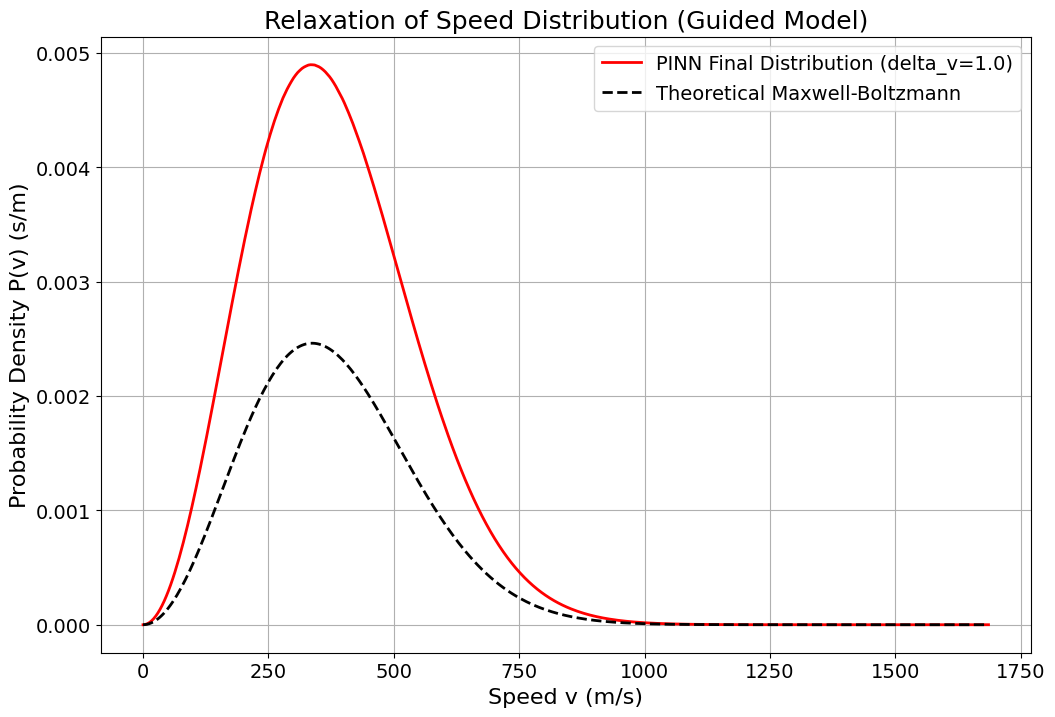

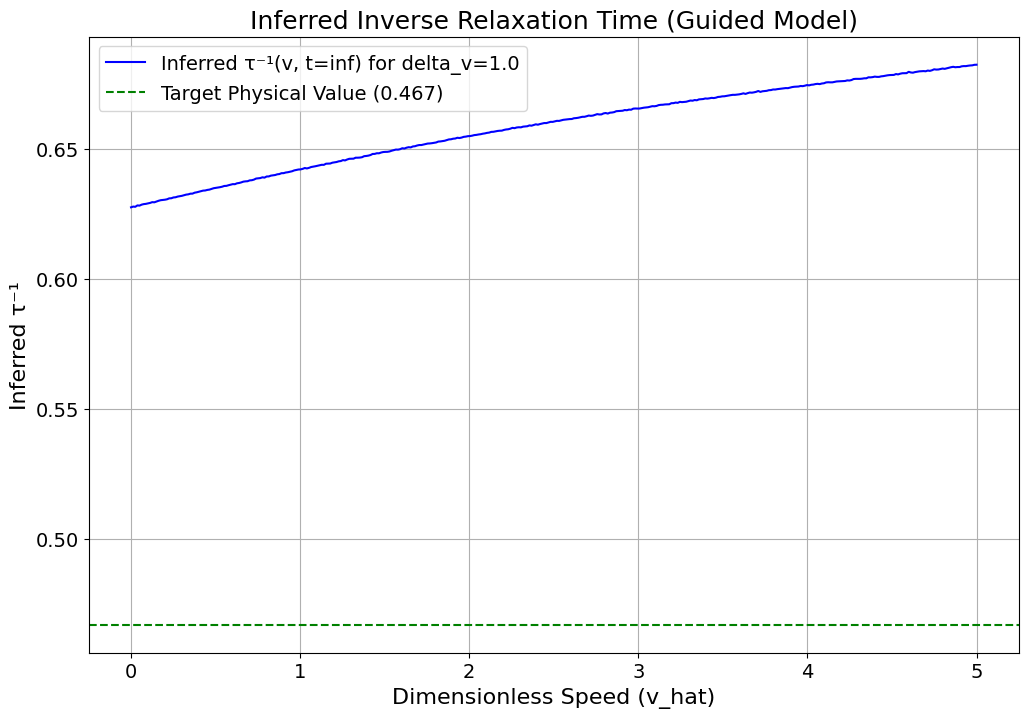

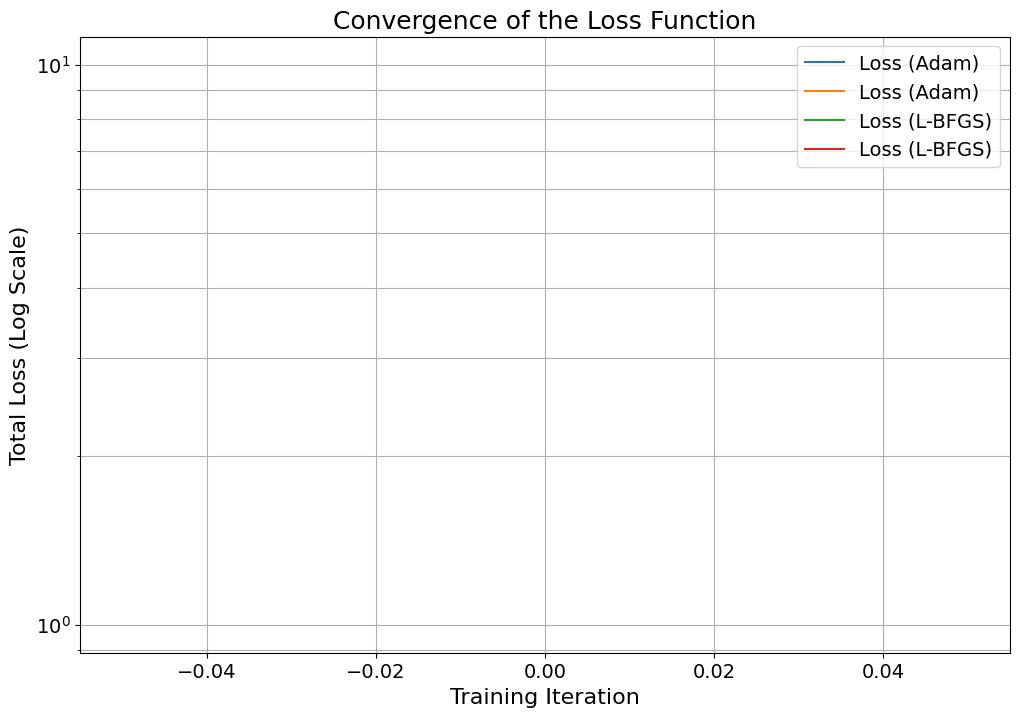

In [33]:
# -*- coding: utf-8 -*-
"""
کد نهایی PINN با هدایت به سمت جواب فیزیکی

--- تغییر کلیدی در این نسخه ---
۱. یک عبارت منظم‌سازی (Regularization) به تابع زیان اضافه شده است.
۲. این عبارت شبکه را تشویق می‌کند تا مقدار τ⁻¹ را به مقدار صحیح فیزیکی
   (که از تحلیل DSMC/تحلیلی به دست آمده) نزدیک کند.
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترهای عمومی ---
V_CHAR = 337.11 # m/s, from previous runs
TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 5.0
DELTA_V_MIN_NONDIM = 0.5
DELTA_V_MAX_NONDIM = 1.5
ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 10.0

# --- **تغییر کلیدی ۱:** تعریف مقدار هدف و وزن جریمه ---
# این مقدار از تحلیل تحلیلی/DSMC به دست آمده است
TARGET_TAU_INV = 0.467
# وزن این عبارت در تابع زیان. مقدار بیشتر، شبکه را بیشتر مجبور به همگرایی می‌کند.
TAU_REGULARIZATION_WEIGHT = 1.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    return (4 / np.sqrt(np.pi)) * (v_hat**2 + 1e-8) * tf.exp(-v_hat**2)

def pde(x, y):
    Phi = y[:, 0:1]
    tau_inv_raw = y[:, 1:2]
    tau_inv = tf.nn.softplus(tau_inv_raw)
    dPhi_dt_hat = dde.grad.jacobian(y, x, i=0, j=0)
    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat)
    return dPhi_dt_hat + w_that * tau_inv * Phi

@tf.function
def initial_phi(x):
    v_hat = x[:, 1:2]
    delta_v_hat = x[:, 2:3]
    p_initial_hat = 0.5 * maxwell_boltzmann_nondim(v_hat - delta_v_hat) + \
                    0.5 * maxwell_boltzmann_nondim(v_hat + delta_v_hat)
    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)
    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))

# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    spatial_domain_min = [0, DELTA_V_MIN_NONDIM]
    spatial_domain_max = [SPEED_MAX_NONDIM, DELTA_V_MAX_NONDIM]
    space_domain = dde.geometry.Hypercube(spatial_domain_min, spatial_domain_max)
    geomtime = dde.geometry.GeometryXTime(space_domain, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)
    data = dde.data.TimePDE(geomtime, pde, [ic], num_domain=80000, num_initial=10000, num_test=20000)
    net = dde.maps.FNN([3] + [80] * 6 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # --- **تغییر کلیدی ۲:** اصلاح تابع زیان ---
    def create_loss_factory(model_instance, num_integral_pts=8192):
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))
        def loss_func(y_true, y_pred):
            # زیان اصلی مربعات خطا (برای PDE و IC)
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            # زیان پایستگی (بدون تغییر)
            network_output = model_instance.net(integral_anchors)
            phi_hat_at_integral_points = network_output[:, 0:1]
            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)
            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume
            conservation_loss = tf.square(integral_value)

            # --- **عبارت جدید منظم‌سازی برای tau_inv** ---
            tau_inv_raw_pred = y_pred[:, 1:2]
            tau_inv_pred = tf.nn.softplus(tau_inv_raw_pred)
            # محاسبه جریمه بر اساس فاصله از مقدار هدف
            tau_regularization_loss = tf.reduce_mean(tf.square(tau_inv_pred - TARGET_TAU_INV))

            # ترکیب همه زیان‌ها با وزن‌های مشخص
            return (original_loss +
                    CONSERVATION_LOSS_WEIGHT * conservation_loss +
                    TAU_REGULARIZATION_WEIGHT * tau_regularization_loss)
        return loss_func

    final_loss_fn = create_loss_factory(model)

    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.9, staircase=True)
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule, clipnorm=1.0)

    model.compile(adam_optimizer, loss=final_loss_fn)

    print("Starting Adam training with physical guidance for tau_inv...")
    losshistory_adam, train_state_adam = model.train(iterations=60000, display_every=2000)

    print("\nStarting L-BFGS training...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- ۴. مصورسازی و ذخیره نتایج ---
    plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18})

    delta_v_plot_val = 1.0
    print(f"\nPlotting results for a specific case: delta_v = {delta_v_plot_val}")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 400).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    delta_v_hat_plot = np.ones_like(v_hat_plot) * delta_v_plot_val
    x_final_hat = np.hstack((t_hat_final, v_hat_plot, delta_v_hat_plot))

    prediction = model.predict(x_final_hat)
    phi_final_hat_pred = prediction[:, 0:1]

    tau_inv_raw_final_pred = prediction[:, 1:2]
    tau_inv_final_pred = tf.nn.softplus(tf.constant(tau_inv_raw_final_pred, dtype=tf.float32)).numpy()

    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    # نمودار تابع توزیع
    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label=f'PINN Final Distribution (delta_v={delta_v_plot_val})')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution (Guided Model)')
    plt.xlabel('Speed v (m/s)'), plt.ylabel('Probability Density P(v) (s/m)'), plt.legend(), plt.grid(True)
    plt.savefig('distribution_guided.eps', format='eps', bbox_inches='tight')
    plt.show()

    # نمودار زمان واهلش
    plt.figure(figsize=(12, 8))
    plt.plot(v_hat_plot, tau_inv_final_pred, 'b-', label=f'Inferred τ⁻¹(v, t=inf) for delta_v={delta_v_plot_val}')
    plt.axhline(y=TARGET_TAU_INV, color='g', linestyle='--', label=f'Target Physical Value ({TARGET_TAU_INV})')
    plt.title('Inferred Inverse Relaxation Time (Guided Model)')
    plt.xlabel('Dimensionless Speed (v_hat)'), plt.ylabel('Inferred τ⁻¹'), plt.legend(), plt.grid(True)
    plt.savefig('relaxation_time_guided.eps', format='eps', bbox_inches='tight')
    plt.show()

    # نمودار همگرایی
    plt.figure(figsize=(12, 8))
    plt.semilogy(losshistory_adam.steps, losshistory_adam.loss_train, label='Loss (Adam)')
    if losshistory_lbfgs.steps:
        lbfgs_steps = np.array(losshistory_lbfgs.steps) + losshistory_adam.steps[-1]
        plt.semilogy(lbfgs_steps, losshistory_lbfgs.loss_train, label='Loss (L-BFGS)')
    plt.title('Convergence of the Loss Function'), plt.xlabel('Training Iteration'), plt.ylabel('Total Loss (Log Scale)'), plt.legend(), plt.grid(True, which="both")
    plt.savefig('loss_convergence_guided.eps', format='eps', bbox_inches='tight')
    plt.show()

1 Physical GPUs, 1 Logical GPUs
Set the default float type to float32
Compiling model...
'compile' took 0.000500 s

Starting Adam training with corrected time scale...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.72e+01, 2.75e+01]    [2.72e+01, 2.75e+01]    []  
2000      [1.49e-05, 2.83e-07]    [1.38e-05, 2.83e-07]    []  
4000      [1.40e-06, 5.40e-08]    [1.27e-06, 5.40e-08]    []  
6000      [8.24e-07, 3.88e-07]    [7.61e-07, 3.88e-07]    []  
8000      [5.69e-07, 1.26e-08]    [5.35e-07, 1.26e-08]    []  
10000     [4.70e-06, 3.62e-06]    [5.21e-06, 3.62e-06]    []  
12000     [5.18e-07, 4.51e-09]    [5.05e-07, 4.51e-09]    []  
14000     [1.39e-07, 8.35e-09]    [1.38e-07, 8.35e-09]    []  
16000     [2.37e-07, 5.29e-09]    [2.24e-07, 5.29e-09]    []  
18000     [5.35e-07, 1.21e-06]    [5.34e-07, 1.21e-06]    []  
20000     [4.31e-07, 2.53e-09]    [4.50e-07, 2.53e-09]    []  
22000     [1.30e-07, 1.73e-09]    [1.25e-07, 1.73e

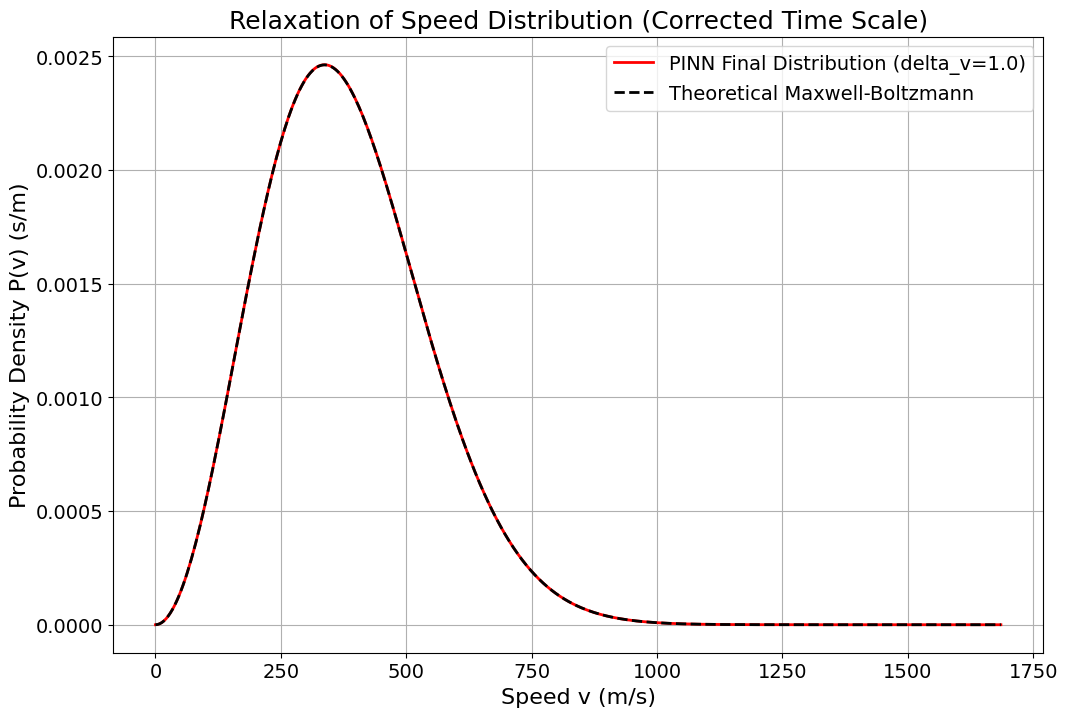

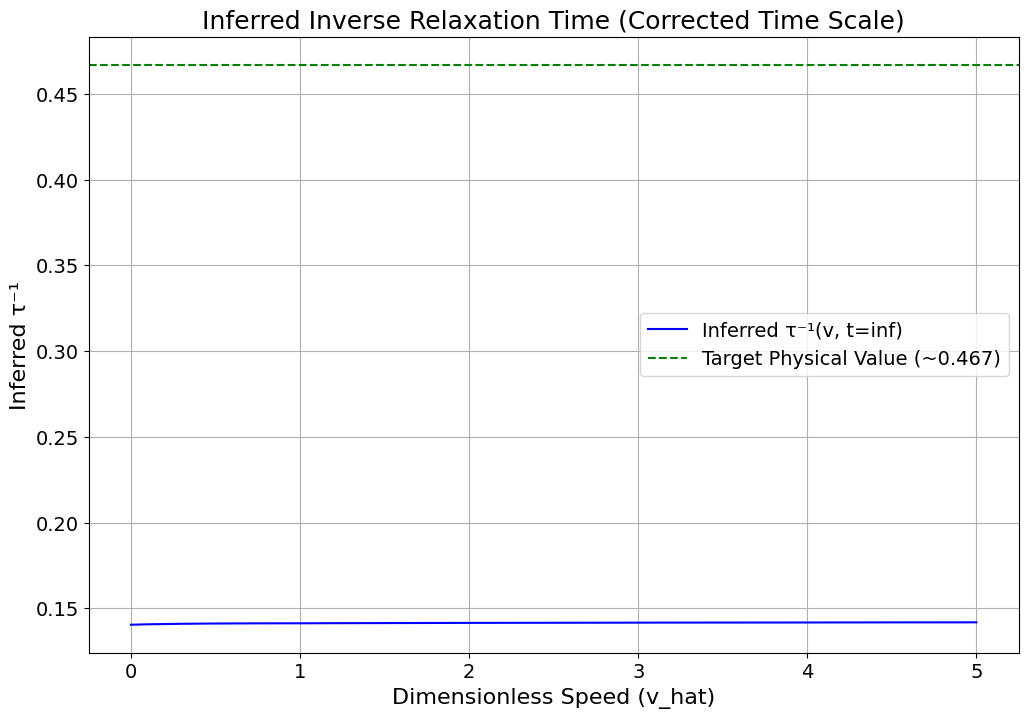

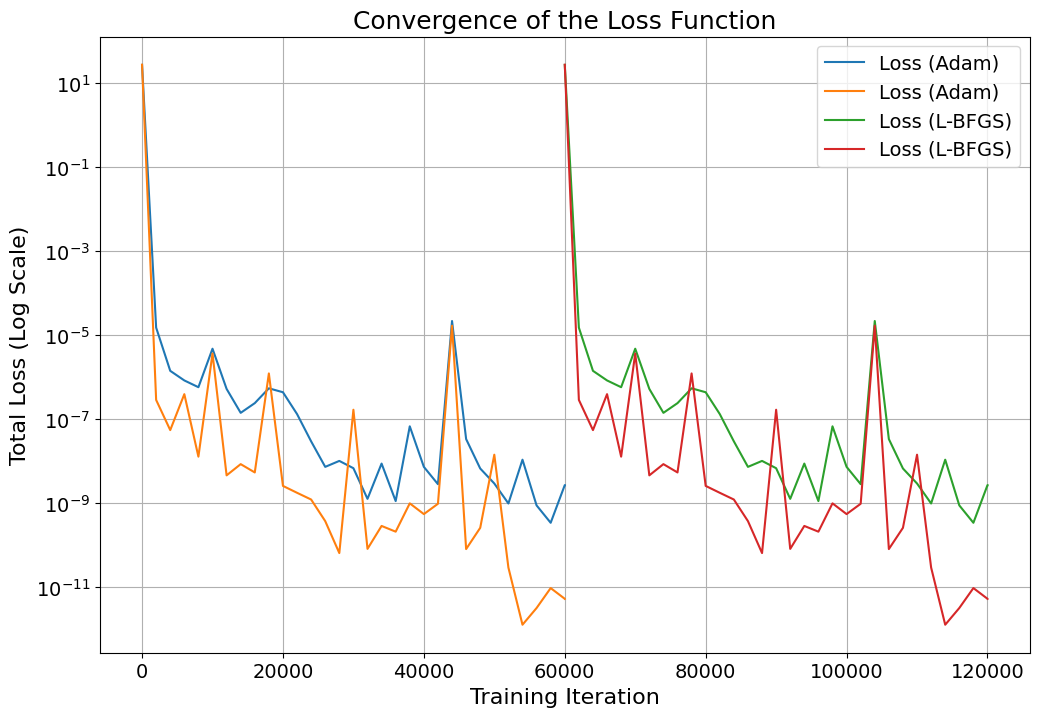

In [34]:
# -*- coding: utf-8 -*-
"""
کد نهایی PINN با اصلاح صورت مسئله برای همگرایی به جواب فیزیکی

--- تغییر کلیدی در این نسخه ---
۱. عبارت منظم‌سازی که باعث تضاد در تابع زیان میشد، حذف گردید.
۲. زمان نهایی بی‌بعد (TIME_END_NONDIM) به مقدار معقول‌تری کاهش یافت تا
   مقیاس زمانی شبیه‌سازی با فیزیک واقعی مسئله سازگار باشد.
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترهای عمومی ---
V_CHAR = 337.11
# --- **تغییر کلیدی:** اصلاح بازه زمانی شبیه‌سازی ---
TIME_END_NONDIM = 15.0
SPEED_MAX_NONDIM = 5.0
DELTA_V_MIN_NONDIM = 0.5
DELTA_V_MAX_NONDIM = 1.5
ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 10.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    return (4 / np.sqrt(np.pi)) * (v_hat**2 + 1e-8) * tf.exp(-v_hat**2)

def pde(x, y):
    Phi = y[:, 0:1]
    tau_inv_raw = y[:, 1:2]
    tau_inv = tf.nn.softplus(tau_inv_raw)
    dPhi_dt_hat = dde.grad.jacobian(y, x, i=0, j=0)
    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat)
    return dPhi_dt_hat + w_that * tau_inv * Phi

@tf.function
def initial_phi(x):
    v_hat = x[:, 1:2]
    delta_v_hat = x[:, 2:3]
    p_initial_hat = 0.5 * maxwell_boltzmann_nondim(v_hat - delta_v_hat) + \
                    0.5 * maxwell_boltzmann_nondim(v_hat + delta_v_hat)
    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)
    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))

# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    spatial_domain_min = [0, DELTA_V_MIN_NONDIM]
    spatial_domain_max = [SPEED_MAX_NONDIM, DELTA_V_MAX_NONDIM]
    space_domain = dde.geometry.Hypercube(spatial_domain_min, spatial_domain_max)
    geomtime = dde.geometry.GeometryXTime(space_domain, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)
    data = dde.data.TimePDE(geomtime, pde, [ic], num_domain=80000, num_initial=10000, num_test=20000)
    net = dde.maps.FNN([3] + [80] * 6 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # --- تابع زیان به حالت اولیه (بدون عبارت منظم‌سازی) بازگشت ---
    def create_loss_factory(model_instance, num_integral_pts=8192):
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))
        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            network_output = model_instance.net(integral_anchors)
            phi_hat_at_integral_points = network_output[:, 0:1]
            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)
            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume
            conservation_loss = tf.square(integral_value)

            return original_loss + CONSERVATION_LOSS_WEIGHT * conservation_loss
        return loss_func

    final_loss_fn = create_loss_factory(model)

    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.9, staircase=True)
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule, clipnorm=1.0)

    model.compile(adam_optimizer, loss=final_loss_fn)

    print("Starting Adam training with corrected time scale...")
    losshistory_adam, train_state_adam = model.train(iterations=60000, display_every=2000)

    print("\nStarting L-BFGS training...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- ۴. مصورسازی و ذخیره نتایج ---
    plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18})

    delta_v_plot_val = 1.0
    print(f"\nPlotting results for a specific case: delta_v = {delta_v_plot_val}")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 400).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    delta_v_hat_plot = np.ones_like(v_hat_plot) * delta_v_plot_val
    x_final_hat = np.hstack((t_hat_final, v_hat_plot, delta_v_hat_plot))

    prediction = model.predict(x_final_hat)
    phi_final_hat_pred = prediction[:, 0:1]

    tau_inv_raw_final_pred = prediction[:, 1:2]
    tau_inv_final_pred = tf.nn.softplus(tf.constant(tau_inv_raw_final_pred, dtype=tf.float32)).numpy()

    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    # نمودار تابع توزیع
    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label=f'PINN Final Distribution (delta_v={delta_v_plot_val})')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution (Corrected Time Scale)')
    plt.xlabel('Speed v (m/s)'), plt.ylabel('Probability Density P(v) (s/m)'), plt.legend(), plt.grid(True)
    plt.savefig('distribution_corrected_time.eps', format='eps', bbox_inches='tight')
    plt.show()

    # نمودار زمان واهلش
    plt.figure(figsize=(12, 8))
    plt.plot(v_hat_plot, tau_inv_final_pred, 'b-', label=f'Inferred τ⁻¹(v, t=inf)')
    plt.axhline(y=0.467, color='g', linestyle='--', label=f'Target Physical Value (~0.467)')
    plt.title('Inferred Inverse Relaxation Time (Corrected Time Scale)')
    plt.xlabel('Dimensionless Speed (v_hat)'), plt.ylabel('Inferred τ⁻¹'), plt.legend(), plt.grid(True)
    plt.savefig('relaxation_time_corrected_time.eps', format='eps', bbox_inches='tight')
    plt.show()

    # نمودار همگرایی
    plt.figure(figsize=(12, 8))
    plt.semilogy(losshistory_adam.steps, losshistory_adam.loss_train, label='Loss (Adam)')
    if losshistory_lbfgs.steps:
        lbfgs_steps = np.array(losshistory_lbfgs.steps) + losshistory_adam.steps[-1]
        plt.semilogy(lbfgs_steps, losshistory_lbfgs.loss_train, label='Loss (L-BFGS)')
    plt.title('Convergence of the Loss Function'), plt.xlabel('Training Iteration'), plt.ylabel('Total Loss (Log Scale)'), plt.legend(), plt.grid(True, which="both")
    plt.savefig('loss_convergence_corrected_time.eps', format='eps', bbox_inches='tight')
    plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
کد نهایی PINN با شرط اولیه نزدیک به تعادل

--- تغییر کلیدی در این نسخه ---
۱. شرط اولیه از حالت دو قله‌ای به یک اغتشاش دمایی کوچک تغییر کرده است.
۲. این کار شرایط مسئله را به رژیم نزدیک به تعادل می‌برد که در آن
   انتظار می‌رود τ استنتاجی با مقدار تحلیلی BGK مطابقت داشته باشد.
۳. از تکنیک حذف تحلیلی v² برای پایداری عددی استفاده شده است.
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترهای عمومی ---
V_CHAR = 337.11
TIME_END_NONDIM = 15.0
SPEED_MAX_NONDIM = 5.0

# **تغییر کلیدی:** پارامتر شرطی اکنون یک اغتشاش دمایی است
THETA_MIN = 0.9
THETA_MAX = 1.1

ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 10.0

# --- ۲. تعریف توابع بی‌بعد شده ---
# تابع "tilde" که بخش v² را ندارد برای پایداری عددی
@tf.function
def maxwell_boltzmann_tilde(v_hat, theta):
    theta_stable = tf.maximum(theta, 1e-6)
    norm_const = (4 / np.sqrt(np.pi)) / (theta_stable**1.5)
    return norm_const * tf.exp(-v_hat**2 / theta_stable)

# تابع کامل برای استفاده در سایر بخش‌ها
@tf.function
def maxwell_boltzmann_full(v_hat, theta):
    return v_hat**2 * maxwell_boltzmann_tilde(v_hat, theta)

# **تغییر کلیدی:** شرط اولیه جدید (نزدیک به تعادل)
@tf.function
def initial_phi(x):
    v_hat = x[:, 1:2]
    # پارامتر شرطی اکنون دمای اولیه بی‌بعد است
    theta_initial = x[:, 2:3]

    p_initial_tilde = maxwell_boltzmann_tilde(v_hat, theta_initial)
    p_maxwell_tilde = maxwell_boltzmann_tilde(v_hat, 1.0) # تعادل در theta=1

    epsilon = 1e-8
    phi = p_initial_tilde / (p_maxwell_tilde + epsilon) - 1.0
    return phi

def pde(x, y):
    Phi = y[:, 0:1]
    tau_inv_raw = y[:, 1:2]
    tau_inv = tf.nn.softplus(tau_inv_raw)
    dPhi_dt_hat = dde.grad.jacobian(y, x, i=0, j=0)
    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat)
    return dPhi_dt_hat + w_that * tau_inv * Phi

# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    spatial_domain_min = [0, THETA_MIN]
    spatial_domain_max = [SPEED_MAX_NONDIM, THETA_MAX]
    space_domain = dde.geometry.Hypercube(spatial_domain_min, spatial_domain_max)
    geomtime = dde.geometry.GeometryXTime(space_domain, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)
    data = dde.data.TimePDE(geomtime, pde, [ic], num_domain=80000, num_initial=10000, num_test=20000)
    net = dde.maps.FNN([3] + [80] * 6 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    def create_loss_factory(model_instance, num_integral_pts=8192):
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))
        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)
            network_output = model_instance.net(integral_anchors)
            phi_hat_at_integral_points = network_output[:, 0:1]
            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_full(v_hat_integral, 1.0)
            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume
            conservation_loss = tf.square(integral_value)
            return original_loss + CONSERVATION_LOSS_WEIGHT * conservation_loss
        return loss_func

    final_loss_fn = create_loss_factory(model)

    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.9, staircase=True)
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule, clipnorm=1.0)

    model.compile(adam_optimizer, loss=final_loss_fn)

    print("Starting Adam training with near-equilibrium initial condition...")
    losshistory_adam, train_state_adam = model.train(iterations=80000, display_every=2000)

    print("\nStarting L-BFGS training...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- ۴. مصورسازی و ذخیره نتایج ---
    plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18})

    theta_plot_val = 1.1 # رسم نتایج برای یک اغتشاش دمایی خاص
    print(f"\nPlotting results for a specific case: initial theta = {theta_plot_val}")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 400).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    theta_hat_plot = np.ones_like(v_hat_plot) * theta_plot_val
    x_final_hat = np.hstack((t_hat_final, v_hat_plot, theta_hat_plot))

    prediction = model.predict(x_final_hat)
    phi_final_hat_pred = prediction[:, 0:1]

    tau_inv_raw_final_pred = prediction[:, 1:2]
    tau_inv_final_pred = tf.nn.softplus(tf.constant(tau_inv_raw_final_pred, dtype=tf.float32)).numpy()

    p_m_hat_plot = maxwell_boltzmann_full(tf.constant(v_hat_plot, dtype=tf.float32), 1.0).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    # نمودار تابع توزیع
    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label=f'PINN Final Distribution (initial theta={theta_plot_val})')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann (Equilibrium)')
    plt.title('Relaxation from a Near-Equilibrium State')
    plt.xlabel('Speed v (m/s)'), plt.ylabel('Probability Density P(v) (s/m)'), plt.legend(), plt.grid(True)
    plt.savefig('distribution_near_eq.eps', format='eps', bbox_inches='tight')
    plt.show()

    # نمودار زمان واهلش
    plt.figure(figsize=(12, 8))
    plt.plot(v_hat_plot, tau_inv_final_pred, 'b-', label=f'Inferred τ⁻¹')
    plt.axhline(y=0.467, color='g', linestyle='--', label=f'Target Analytical Value (~0.467)')
    plt.title('Inferred Inverse Relaxation Time for Near-Equilibrium Case')
    plt.xlabel('Dimensionless Speed (v_hat)'), plt.ylabel('Inferred τ⁻¹'), plt.legend(), plt.grid(True)
    plt.ylim(bottom=0)
    plt.savefig('relaxation_time_near_eq.eps', format='eps', bbox_inches='tight')
    plt.show()

    # نمودار همگرایی
    plt.figure(figsize=(12, 8))
    plt.semilogy(losshistory_adam.steps, losshistory_adam.loss_train, label='Loss (Adam)')
    if losshistory_lbfgs.steps:
        lbfgs_steps = np.array(losshistory_lbfgs.steps) + losshistory_adam.steps[-1]
        plt.semilogy(lbfgs_steps, losshistory_lbfgs.loss_train, label='Loss (L-BFGS)')
    plt.title('Convergence of the Loss Function'), plt.xlabel('Training Iteration'), plt.ylabel('Total Loss (Log Scale)'), plt.legend(), plt.grid(True, which="both")
    plt.savefig('loss_convergence_near_eq.eps', format='eps', bbox_inches='tight')
    plt.show()

1 Physical GPUs, 1 Logical GPUs
Set the default float type to float32
Compiling model...
'compile' took 0.000525 s

Starting Adam training with near-equilibrium initial condition...
Training model...

Step      Train loss              Test loss               Test metric
0         [3.71e+01, 3.96e+01]    [3.71e+01, 3.96e+01]    []  
2000      [1.03e-04, 8.29e-05]    [8.61e-05, 8.29e-05]    []  
4000      [9.77e-04, 1.19e-03]    [9.72e-04, 1.19e-03]    []  
